In [25]:
import yaml

import sys
sys.path.append('/sdf/data/neutrino/software/spine/src')

from spine.driver import Driver
from spine.vis import Drawer

%matplotlib inline

cfg = '''
base:
  verbosity: info
build:
  mode: both
  fragments: false
  particles: true
  interactions: true
  units: cm
io:
  reader:
    file_keys: DATA_PATH
    name: hdf5
'''.replace('DATA_PATH', '/sdf/data/neutrino/ndlar/spine/prod/nuone/output_spine/MicroProdN3p2_NDLAr_2E22_FHC_NuE.flow2supera.ndlarfid.singles.000024[0-9].LARCV_spine.h5')

#replace('DATA_PATH', '/sdf/home/l/liuty/NuEEL/data/nuone/.ipynb_checkpoints/nuone.h5')
#replace('DATA_PATH', '/sdf/data/neutrino/ndlar/spine/prod/nuone/output_spine/MicroProdN3p2_NDLAr_2E22_FHC_NuE.flow2supera.ndlarfid.singles.000024[0-9].LARCV_spine.h5')

driver = Driver(yaml.safe_load(cfg))


 ██████████   ██████████    ███   ███       ██   ███████████
███        █  ██       ███   █    █████     ██   ██         
  ████████    ██       ███  ███   ██  ████  ██   ██████████ 
█        ███  ██████████     █    ██     █████   ██         
 ██████████   ██            ███   ██       ███   ███████████

Release version: 0.7.7

$CUDA_VISIBLE_DEVICES=None

Release version: 0.7.7

$CUDA_VISIBLE_DEVICES=None

Configuration processed at: Linux sdfrome054 4.18.0-372.32.1.el8_6.x86_64 #1 SMP Fri Oct 7 12:35:10 EDT 2022 x86_64 x86_64 x86_64 GNU/Linux

base: {verbosity: info, world_size: 0, seed: 1765397449}
io:
  reader: {file_keys: '/sdf/data/neutrino/ndlar/spine/prod/nuone/output_spine/MicroProdN3p2_NDLAr_2E22_FHC_NuE.flow2supera.ndlarfid.singles.000024[0-9].LARCV_spine.h5',
    name: hdf5}
build: {mode: both, fragments: false, particles: true, interactions: true, units: cm}

Configuration processed at: Linux sdfrome054 4.18.0-372.32.1.el8_6.x86_64 #1 SMP Fri Oct 7 12:35:10 EDT 2022 x86_64

# Data process

In [26]:
# This cell processes all data for values relevant to purity

import numpy as np
from tqdm import tqdm
from tqdm.notebook import tqdm
from time import sleep, time
from spine.utils.geo import Geometry
from data_process_modules import extract_particle_features, compute_shower_dqdx, pca_analysis
import pickle
import os

# Define data save path
data_save_path = '/sdf/home/l/liuty/NuEEL/upload/data/cut_nuone_processed_data.pkl'

# Check if processed data already exists
if os.path.exists(data_save_path):
    print(f"Loading processed data from {data_save_path}...")
    with open(data_save_path, 'rb') as f:
        saved_data = pickle.load(f)
    
    # Load all variables
    interaction_count = saved_data['interaction_count']
    file_index = saved_data['file_index']
    index = saved_data['index']
    event_id = saved_data['event_id']
    true_id = saved_data['true_id']
    true_inter_id = saved_data['true_inter_id']
    reco_id = saved_data['reco_id']
    indices_NUEEL = saved_data['indices_NUEEL']
    current_type = saved_data['current_type']
    target = saved_data['target']
    interaction_mode = saved_data['interaction_mode']
    interaction_type = saved_data['interaction_type']
    true_energy = saved_data['true_energy']
    true_topology = saved_data['true_topology']
    true_pdg = saved_data['true_pdg']
    true_dedx_list = saved_data['true_dedx_list']
    true_particle_info = saved_data['true_particle_info']
    true_pca_variables = saved_data['true_pca_variables']
    reco_vertex = saved_data['reco_vertex']
    reco_topology = saved_data['reco_topology']
    reco_dedx_list = saved_data['reco_dedx_list']
    reco_particle_info = saved_data['reco_particle_info']
    reco_pca_variables = saved_data['reco_pca_variables']
    
    print(f"Data loaded successfully! Total interactions: {interaction_count}")
    print(f"NUEEL indices: {indices_NUEEL}")
    
else:
    print("Processing data from scratch...")
    
    interaction_count = 0

    # General info
    file_index = []
    index = []
    event_id = []
    true_id = []
    true_inter_id = []
    reco_id = []
    indices_NUEEL = []

    # Detailed info for cuts
        # truth info
    current_type = []
    target = []
    interaction_mode = []
    interaction_type = []
    true_energy = []
    true_topology = []
    true_pdg = []
    true_dedx_list = []
    true_particle_info = []
    true_pca_variables = []

        # reco info
    reco_vertex = []
    reco_topology = []
    reco_dedx_list = []
    reco_particle_info = [] # shape: [[{info of particle 1 of interaction 1}], [{info of particle 1 of interaction 2}, {info of particle 2 of interaction 2}], ...]
    reco_pca_variables = []

    geo = Geometry('ndlar')

    for data in tqdm(driver):
        for truth, reco in data['interaction_matches_t2r']:
            
            cur_type = truth.current_type
            targ = truth.target
            inter_mode = truth.interaction_mode
            inter_type = truth.interaction_type
            energy = truth.energy_init
            true_top = truth.topology
            pdg = truth.pdg_code
            
            file_index.append(data['file_index'])
            index.append(data['index'])
            event_id.append(data['run_info'].event)
            true_id.append(truth.id)
            current_type.append(cur_type)
            target.append(targ)
            interaction_mode.append(inter_mode)
            interaction_type.append(inter_type)
            true_energy.append(energy)
            true_topology.append(true_top)
            true_pdg.append(pdg)
            true_inter_id.append(truth.interaction_id)
            true_dedx = compute_shower_dqdx(truth)
            true_dedx_list.append(true_dedx)
            
            # Truth particle info
            info = []
            points = []
            for _, particle in enumerate(truth.particles):
                points.append(particle.points)
                info.append(extract_particle_features(particle))
            true_particle_info.append(info)
            points_combined = np.vstack(points)
            true_pca_variables.append(pca_analysis(points_combined))
            
            # Check if this is a NUEEL event
            if true_top == '1e' and inter_mode == 7:
                indices_NUEEL.append(interaction_count)
            
            # Reco may or may not exist
            if reco is None:
                # No reco match
                reco_id.append('')
                reco_topology.append('')
                reco_vertex.append(np.array([np.nan, np.nan, np.nan]))
                reco_dedx_list.append(np.nan)
                reco_particle_info.append([])
                reco_pca_variables.append('')
            else:
                # Reco exists
                reco_id.append(reco.id)
                reco_top = reco.topology
                reco_topology.append(reco_top)
                reco_vertex.append(reco.vertex)
                reco_dedx = compute_shower_dqdx(reco)
                reco_dedx_list.append(reco_dedx)

                # Collect particle info for each interaction
                info = []
                points = []
                for _, particle in enumerate(reco.particles):
                    points.append(particle.points)
                    info.append(extract_particle_features(particle))
                reco_particle_info.append(info)
                points_combined = np.vstack(points)
                reco_pca_variables.append(pca_analysis(points_combined))
                
            interaction_count += 1

    print('Total interactions analyzed: ', interaction_count)
    print('NUEEL indices:', indices_NUEEL)
    
    # Save processed data
    print(f"Saving processed data to {data_save_path}...")
    os.makedirs(os.path.dirname(data_save_path), exist_ok=True)
    
    data_to_save = {
        'interaction_count': interaction_count,
        'file_index': file_index,
        'index': index,
        'event_id': event_id,
        'true_id': true_id,
        'true_inter_id': true_inter_id,
        'reco_id': reco_id,
        'indices_NUEEL': indices_NUEEL,
        'current_type': current_type,
        'target': target,
        'interaction_mode': interaction_mode,
        'interaction_type': interaction_type,
        'true_energy': true_energy,
        'true_topology': true_topology,
        'true_pdg': true_pdg,
        'true_dedx_list': true_dedx_list,
        'true_particle_info': true_particle_info,
        'true_pca_variables': true_pca_variables,
        'reco_vertex': reco_vertex,
        'reco_topology': reco_topology,
        'reco_dedx_list': reco_dedx_list,
        'reco_particle_info': reco_particle_info,
        'reco_pca_variables': reco_pca_variables
    }
    
    with open(data_save_path, 'wb') as f:
        pickle.dump(data_to_save, f)
    
    print("Data saved successfully!")

Loading processed data from /sdf/home/l/liuty/NuEEL/upload/data/cut_nuone_processed_data.pkl...
Data loaded successfully! Total interactions: 8795
NUEEL indices: [0, 1, 2, 3, 5, 6, 8, 10, 13, 14, 18, 19, 20, 22, 23, 24, 25, 26, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 45, 48, 49, 51, 52, 54, 56, 57, 59, 60, 61, 62, 63, 65, 66, 68, 71, 73, 74, 76, 78, 79, 80, 81, 82, 83, 84, 86, 87, 89, 90, 91, 94, 95, 96, 100, 102, 103, 104, 106, 107, 108, 110, 111, 112, 114, 115, 116, 117, 119, 120, 122, 123, 125, 126, 128, 129, 130, 131, 132, 134, 135, 137, 138, 139, 141, 142, 143, 145, 146, 147, 148, 149, 150, 151, 153, 154, 157, 158, 159, 160, 161, 162, 165, 166, 168, 169, 171, 173, 174, 176, 177, 178, 180, 181, 182, 183, 184, 185, 186, 188, 189, 194, 196, 197, 199, 200, 201, 202, 203, 204, 205, 206, 208, 209, 210, 212, 213, 215, 216, 217, 218, 220, 223, 225, 227, 228, 230, 231, 233, 234, 235, 236, 237, 238, 239, 241, 242, 243, 244, 245, 246, 247, 251, 253, 254, 255, 257, 258, 260, 261, 

[6067, 2003, 725]
['1e', '1e', '1g1pi', '1g', '1e', '1e', '1g', '1g', '1g', '1g1pi1p', '1g', '1e', '1e', '1g', '1e', '1e', '1g', '1g1e', '1mu', '1g', '14e', '1e', '1g', '', '2e', '1g', '1g', '1g', '1e', '3e', '1e', '1e', '43e', '1g1pi', '1e1pi', '1g', '1g', '1e', '1g', '2g', '1e', '1pi2p1ka', '1g', '1e', '1pi', '1g', '56e', '1g', '1g', '1g', '4e', '2e', '1g', '1e', '1e', '1e', '1g', '1e1pi1p', '1e', '1e', '1g', '1g', '16e', '1g', '1g', '1e', '1g', '2g107e4pi3p4ka', '1g', '1g', '1g', '1g', '1e', '1g11e6pi3p2ka', '1g', '15e1pi3p4ka', '4e', '84e1mu2pi14p10ka', '1g', '2e', '1g', '1e', '1g', '', '1e', '1e', '1g', '1g', '1g', '1e', '1g', '1e', '1g', '1g1pi', '1g', '1e', '1g', '1g', '1g', '4e', '1g', '1g', '1e', '1g', '1g', '3e2p', '1e', '1g', '1g', '1e', '1e', '1e', '1g', '1g', '1g', '1g', '1g', '1e', '1g', '1g', '1g', '1g', '1g', '1mu', '1e', '1g1pi', '5e', '1e', '1g', '1e', '1g', '1g', '1e1pi', '1g', '1e', '1g', '66e1p1ka', '1g3e', '1g', '1g1e', '1e', '1mu', '3e', '1e', '1e', '1e', '1g', '

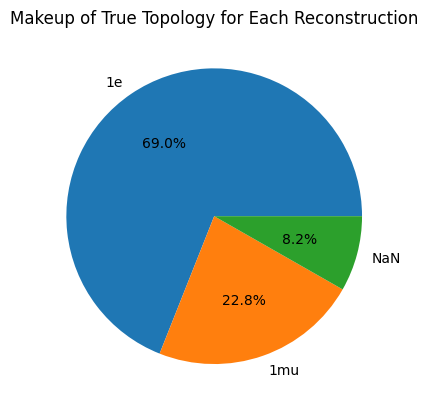

In [27]:
import matplotlib.pyplot as plt
from collections import Counter

reco_topology_corresponding_to_true_1e = []
for i in range(len(true_topology)):
    if true_topology[i] == '1e':
        reco_topology_corresponding_to_true_1e.append(reco_topology[i])

def get_top100(data):
    total = len(data)
    counter = Counter(data)
    top100 = counter.most_common(100)
    top100_labels = [str(item[0]) if item[0] != '' else 'NaN' for item in top100]
    top100_counts = [item[1] for item in top100 ]
    
    labels = top100_labels
    sizes = [(count / total) * 100 for count in top100_counts]
    print(top100_counts)
    
    return labels, sizes

# Pie chart
labels, sizes = get_top100(true_topology)
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
ax.set_title("Makeup of True Topology for Each Reconstruction")

print(reco_topology_corresponding_to_true_1e)

# Params

In [28]:
# ============================================================================
# Cut Parameters
# ============================================================================

# ============================================================================
# Cut Enable/Disable Switches
# ============================================================================
ENABLE_TOPOLOGY_CUT = True
ENABLE_FIDUCIAL_CUT = True
ENABLE_ANGLE_CUT = True
ENABLE_DEDX_CUT = True
ENABLE_ETHETA2_CUT = True
ENABLE_KE_CUT = True
ENABLE_PCA_CUT = True
ENABLE_PROXIMITY_CUT = True

# ============================================================================
# Cut Parameter Values
# ============================================================================

# Angle cut: maximum angle between particle and beam direction (degrees)
ANGLE_CUT_MAX = 7.0  # degrees

# Reco topology cut: allowed reconstruction topology types
RECO_TOPOLOGY_ALLOWED = ['1e', '1g']

# dE/dx cut: allowed range for initial dE/dx (MeV/cm)
DEDX_CUT_MIN = -1.2   # MeV/cm
DEDX_CUT_MAX = 2.5   # MeV/cm

# Eθ² cut: maximum value of kinetic energy × angle squared (MeV·rad²)
ETHETA2_CUT_MAX = 3.0  # MeV·rad²

# KE cut: minimum particle kinetic energy (MeV)
KE_CUT_MIN = 150.0  # MeV

# Fiducial volume margin (cm)
MARGIN_MODULE = 1.5  # cm
MARGIN_DETECTOR = 5.0  # cm

# DELTA_D cut: angular spread. Not in use.
DELTA_D_CUT_MAX = 999999999999
DELTA_D_CUT_MIN = -999999999999

"""PCA Cuts:"""
# PCA axis 1 wrt beam direction. Not in use (prefer start_dir angle cut).
PCA_PC1_ANGLE_MAX = 99999999999  # degrees

# Longitudinal spread (sqrt(λ1)) range
PCA_LONGITUDINAL_MIN = -2      # cm
PCA_LONGITUDINAL_MAX = 99960      # cm

# Major transverse spread (sqrt(λ2)/sqrt(λ1)) range
PCA_TRANSVERSE_MAJOR_MIN = 0.04      
PCA_TRANSVERSE_MAJOR_MAX = 9990.4      

# Minor transverse spread (sqrt(λ3)/sqrt(λ1)) range
PCA_TRANSVERSE_MINOR_MIN = 0.02      
PCA_TRANSVERSE_MINOR_MAX = 9990.2

# Distance threshold (cm)
PROXIMITY_DISTANCE_THRESHOLD = 0.5


print("=" * 60)
print("Cut Parameters Configuration")
print("=" * 60)
print("\nCut Switches:")
print(f"  Topology Cut: {'ENABLED' if ENABLE_TOPOLOGY_CUT else 'DISABLED'}")
print(f"  Fiducial Volume Cut: {'ENABLED' if ENABLE_FIDUCIAL_CUT else 'DISABLED'}")
print(f"  Angle Cut: {'ENABLED' if ENABLE_ANGLE_CUT else 'DISABLED'}")
print(f"  dE/dx Cut: {'ENABLED' if ENABLE_DEDX_CUT else 'DISABLED'}")
print(f"  Eθ² Cut: {'ENABLED' if ENABLE_ETHETA2_CUT else 'DISABLED'}")
print(f"  KE Cut: {'ENABLED' if ENABLE_KE_CUT else 'DISABLED'}")
print(f"  PCA Cut: {'ENABLED' if ENABLE_PCA_CUT else 'DISABLED'}")
print(f"  Proximity Cut: {'ENABLED' if ENABLE_PROXIMITY_CUT else 'DISABLED'}")
print("\nCut Parameter Values:")
print(f"  Angle cut: < {ANGLE_CUT_MAX}°")
print(f"  Reco topology: {RECO_TOPOLOGY_ALLOWED}")
print(f"  dE/dx range: [{DEDX_CUT_MIN}, {DEDX_CUT_MAX}] MeV/cm")
print(f"  Eθ² cut: < {ETHETA2_CUT_MAX} MeV·rad²")
print(f"  KE cut: > {KE_CUT_MIN} MeV")
print(f"  DELTA_D cut: [{DELTA_D_CUT_MIN}, {DELTA_D_CUT_MAX}] (Not in use)")
print(f"\nPCA Cuts:")
print(f"  PC1 angle: < {PCA_PC1_ANGLE_MAX}° (Not in use)")
print(f"  Longitudinal sqrt(λ1): [{PCA_LONGITUDINAL_MIN}, {PCA_LONGITUDINAL_MAX}] cm")
print(f"  Transverse major sqrt(λ2)/sqrt(λ1): [{PCA_TRANSVERSE_MAJOR_MIN}, {PCA_TRANSVERSE_MAJOR_MAX}]")
print(f"  Transverse minor sqrt(λ3)/sqrt(λ1): [{PCA_TRANSVERSE_MINOR_MIN}, {PCA_TRANSVERSE_MINOR_MAX}]")
print(f"\nProximity Cut:")
print(f"  Distance threshold: {PROXIMITY_DISTANCE_THRESHOLD} cm")
print("=" * 60)

Cut Parameters Configuration

Cut Switches:
  Topology Cut: ENABLED
  Fiducial Volume Cut: ENABLED
  Angle Cut: ENABLED
  dE/dx Cut: ENABLED
  Eθ² Cut: ENABLED
  KE Cut: ENABLED
  PCA Cut: ENABLED
  Proximity Cut: ENABLED

Cut Parameter Values:
  Angle cut: < 7.0°
  Reco topology: ['1e', '1g']
  dE/dx range: [-1.2, 2.5] MeV/cm
  Eθ² cut: < 3.0 MeV·rad²
  KE cut: > 150.0 MeV
  DELTA_D cut: [-999999999999, 999999999999] (Not in use)

PCA Cuts:
  PC1 angle: < 99999999999° (Not in use)
  Longitudinal sqrt(λ1): [-2, 99960] cm
  Transverse major sqrt(λ2)/sqrt(λ1): [0.04, 9990.4]
  Transverse minor sqrt(λ3)/sqrt(λ1): [0.02, 9990.2]

Proximity Cut:
  Distance threshold: 0.5 cm


# Cut 1: Topology

In [29]:
# Cut 1: topology

indices_after_topo_cut = []
indices_true_1e = []
indices_of_remaining_nuone = []

count=0
for i in range(len(true_topology)):
    if true_topology[i] == '1e':
        count += 1
print(count)

if ENABLE_TOPOLOGY_CUT:
    for i in range(len(reco_topology)):
        if true_topology[i] == '1e' and reco_topology[i] in RECO_TOPOLOGY_ALLOWED: # topology must be 1e or 1g
            flag_non_em_particle_exist = False
            for j, info in enumerate(reco_particle_info[i]):
                if info['particle_pid'] > 100: # not e or g
                    flag_non_em_particle_exist = True
                    break
            if not flag_non_em_particle_exist:
                indices_after_topo_cut.append(i)

        if true_topology[i] == '1e':
            indices_true_1e.append(i)

    print(f"Topology Cut: ENABLED")
    print(f"Pass Topology cut: {len(indices_after_topo_cut)} / {count}")
    print(f"Pass rate: {len(indices_after_topo_cut)/count*100:.2f}%")
else:
    # If cut is disabled, pass all interactions
    indices_after_topo_cut = list(range(len(reco_topology)))
    for i in range(len(true_topology)):
        if true_topology[i] == '1e':
            indices_true_1e.append(i)
    print(f"Topology Cut: DISABLED (all {len(indices_after_topo_cut)} interactions passed)")

indices_of_remaining_nuone = indices_after_topo_cut.copy()

6067
Topology Cut: ENABLED
Pass Topology cut: 4863 / 6067
Pass rate: 80.15%
Topology Cut: ENABLED
Pass Topology cut: 4863 / 6067
Pass rate: 80.15%


# Cut 2: Fiducial Volume

## Cut

In [30]:
# Cut 2: Fiducial Volume cut
import numpy as np

indices_after_fiducial_cut = []

if ENABLE_FIDUCIAL_CUT:
    geo.define_containment_volumes(margin=MARGIN_MODULE, mode='module')
    geo1 = Geometry('ndlar')
    geo1.define_containment_volumes(margin=MARGIN_DETECTOR, mode='detector')

    cathode_x = [-300, -200, -100, 0, 100, 200, 300]

    for i in indices_after_topo_cut:
        # Check if vertex is within fiducial volume
        if not geo.check_containment(reco_vertex[i]):
            continue
        if not geo1.check_containment(reco_vertex[i]):
            continue

        # Check if vertex x is too close to cathode surfaces
        vertex_x = reco_vertex[i][0]
        too_close_to_cathode = False
        for boundary_x in cathode_x:
            if abs(vertex_x - boundary_x) < MARGIN_MODULE:
                too_close_to_cathode = True
                break

        if not too_close_to_cathode:
            indices_after_fiducial_cut.append(i)

    # Print summary
    print("\n" + "=" * 60)
    print("Fiducial Volume Cut: ENABLED")
    print("=" * 60)
    print(f"After last cut: {len(indices_after_topo_cut)} interactions")
    print(f"Pass fiducial volume cut: {len(indices_after_fiducial_cut)} / {count} interactions")
    print(f"Efficiency: {len(indices_after_fiducial_cut)/count*100:.2f}%")
    print("=" * 60)
else:
    # If cut is disabled, pass all interactions from previous cut
    indices_after_fiducial_cut = indices_after_topo_cut.copy()
    print("\n" + "=" * 60)
    print("Fiducial Volume Cut: DISABLED")
    print(f"All {len(indices_after_fiducial_cut)} interactions passed")
    print("=" * 60)

indices_of_remaining_nuone = indices_after_fiducial_cut.copy()


Fiducial Volume Cut: ENABLED
After last cut: 4863 interactions
Pass fiducial volume cut: 3753 / 6067 interactions
Efficiency: 61.86%


# Cut 3: Angle Cut

## Distrubution

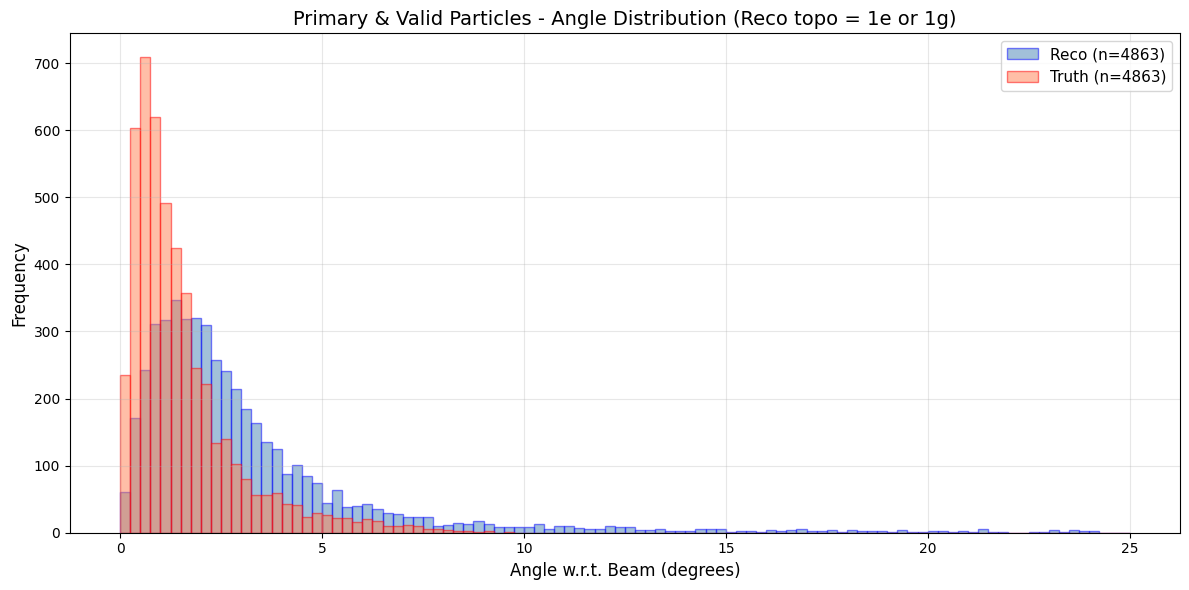

RECO:
  Total particles: 4863
  Mean: 4.16°
  Median: 2.28°
  Std: 9.14°

TRUTH:
  Total particles: 4863
  Mean: 1.55°
  Median: 1.13°
  Std: 1.39°


In [31]:
import matplotlib.pyplot as plt

angle_list_reco = []
angle_list_truth = []

for i in indices_true_1e:
    if i not in indices_after_topo_cut:
        continue
    for particle_dict in reco_particle_info[i]:
        if particle_dict['primary'] and particle_dict['valid']:
            angle = particle_dict['angle_wrt_beam']
            angle_list_reco.append(angle)

for i in indices_true_1e:
    if i not in indices_after_topo_cut:
        continue
    for particle_dict in true_particle_info[i]:
        if particle_dict['primary'] and particle_dict['valid']:
            angle = particle_dict['angle_wrt_beam']
            angle_list_truth.append(angle)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist(angle_list_reco, bins=100, range=(0, 25), edgecolor='blue', alpha=0.5, 
        color='steelblue', label=f'Reco (n={len(angle_list_reco)})')
ax.hist(angle_list_truth, bins=100, range=(0, 25), edgecolor='red', alpha=0.5, 
        color='coral', label=f'Truth (n={len(angle_list_truth)})')

ax.set_xlabel('Angle w.r.t. Beam (degrees)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Primary & Valid Particles - Angle Distribution (Reco topo = 1e or 1g)', fontsize=14)
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=" * 60)
print("RECO:")
print(f"  Total particles: {len(angle_list_reco)}")
print(f"  Mean: {np.mean(angle_list_reco):.2f}°")
print(f"  Median: {np.median(angle_list_reco):.2f}°")
print(f"  Std: {np.std(angle_list_reco):.2f}°")

print("\nTRUTH:")
print(f"  Total particles: {len(angle_list_truth)}")
print(f"  Mean: {np.mean(angle_list_truth):.2f}°")
print(f"  Median: {np.median(angle_list_truth):.2f}°")
print(f"  Std: {np.std(angle_list_truth):.2f}°")
print("=" * 60)


In [32]:
# Export angle distribution data to CSV
import pandas as pd
import os

# Create data directory if not exists
data_dir = './data'
os.makedirs(data_dir, exist_ok=True)

# Export angle data
angle_data = pd.DataFrame({
    'angle_reco': angle_list_reco,
})
angle_data.to_csv(f'{data_dir}/nuone_angle_reco.csv', index=False)

angle_data_truth = pd.DataFrame({
    'angle_truth': angle_list_truth,
})
angle_data_truth.to_csv(f'{data_dir}/nuone_angle_truth.csv', index=False)

print(f"Exported angle data to {data_dir}")
print(f"  - nuone_angle_reco.csv: {len(angle_list_reco)} entries")
print(f"  - nuone_angle_truth.csv: {len(angle_list_truth)} entries")

Exported angle data to ./data
  - nuone_angle_reco.csv: 4863 entries
  - nuone_angle_truth.csv: 4863 entries


## Cut

In [33]:
# Cut 3: Angle cut
import numpy as np
import matplotlib.pyplot as plt

indices_after_angle_cut = []

warning_zero_particles = 0
warning_multiple_particles = 0

if ENABLE_ANGLE_CUT:
    for i in indices_after_fiducial_cut:
        particle_list = reco_particle_info[i]
        
        # Warnings if not exactly 1 primary valid particle
        num_primary_valid_particles = sum(1 for p in particle_list if p['primary'] and p['valid'])
        if num_primary_valid_particles == 0:
            print(f"Warning: Interaction {i} has 0 primary & valid particles")
            warning_zero_particles += 1
            indices_after_angle_cut.append(i)
            continue
        elif num_primary_valid_particles > 1:
            print(f"Warning: Interaction {i} has {num_primary_valid_particles} primary & valid particles")
            warning_multiple_particles += 1
            indices_after_angle_cut.append(i)
            continue
        
        for j in range(len(reco_particle_info[i])):
             if reco_particle_info[i][j]['primary'] and reco_particle_info[i][j]['valid']:
                angle = reco_particle_info[i][j]['angle_wrt_beam']
                if angle < ANGLE_CUT_MAX:
                        indices_after_angle_cut.append(i)
                break

    # Print summary
    print("\n" + "=" * 60)
    print("Angle Cut: ENABLED")
    print("=" * 60)
    print(f"After last cut: {len(indices_after_fiducial_cut)} interactions")
    print(f"Pass angle cut: {len(indices_after_angle_cut)} / {count} interactions")
    print(f"Efficiency: {len(indices_after_angle_cut)/count*100:.2f}%")
    print(f"\nWarnings:")
    print(f"  Interactions with 0 primary & valid particles: {warning_zero_particles}")
    print(f"  Interactions with >1 primary & valid particles: {warning_multiple_particles}")
    print("=" * 60)
else:
    # If cut is disabled, pass all interactions from previous cut
    indices_after_angle_cut = indices_after_fiducial_cut.copy()
    print("\n" + "=" * 60)
    print("Angle Cut: DISABLED")
    print(f"All {len(indices_after_angle_cut)} interactions passed")
    print("=" * 60)

indices_of_remaining_nuone = indices_after_angle_cut.copy()


Angle Cut: ENABLED
After last cut: 3753 interactions
Pass angle cut: 3474 / 6067 interactions
Efficiency: 57.26%

Warnings:
  Interactions with 0 primary & valid particles: 0
  Interactions with >1 primary & valid particles: 0


# Cut 4: dE/dx

## Disribution

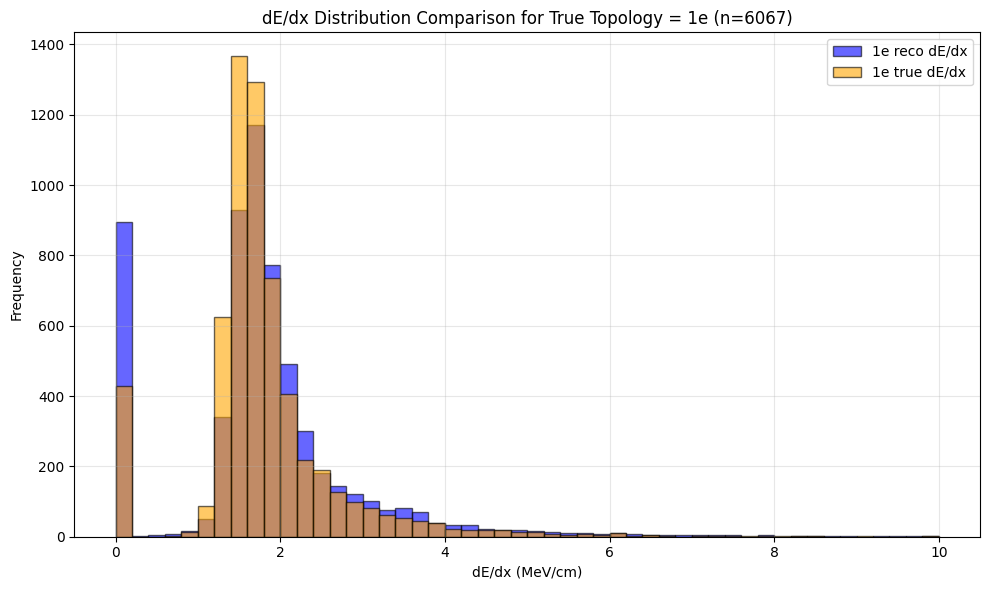

Total events with true_topology='1e': 6067

Reco dE/dx statistics:
  Mean: 1.88
  Median: 1.73
  Std: 1.98

True dE/dx statistics:
  Mean: 1.89
  Median: 1.67
  Std: 1.80


In [34]:
import matplotlib.pyplot as plt
import numpy as np

indices_1e = [i for i in range(len(true_topology)) if true_topology[i] == '1e']

reco_dedx_for_1e = [reco_dedx_list[i] for i in indices_1e]
true_dedx_for_1e = [true_dedx_list[i] for i in indices_1e]

fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(reco_dedx_for_1e, bins=50, range=(0, 10), edgecolor='black', alpha=0.6, label='1e reco dE/dx', color='blue')
ax.hist(true_dedx_for_1e, bins=50, range=(0, 10), edgecolor='black', alpha=0.6, label='1e true dE/dx', color='orange')
ax.set_xlabel('dE/dx (MeV/cm)')
ax.set_ylabel('Frequency')
ax.set_title(f'dE/dx Distribution Comparison for True Topology = 1e (n={len(reco_dedx_for_1e)})')
#ax.set_xlim(0, 10)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Total events with true_topology='1e': {len(indices_1e)}")
print(f"\nReco dE/dx statistics:")
print(f"  Mean: {np.mean(reco_dedx_for_1e):.2f}")
print(f"  Median: {np.median(reco_dedx_for_1e):.2f}")
print(f"  Std: {np.std(reco_dedx_for_1e):.2f}")
print(f"\nTrue dE/dx statistics:")
print(f"  Mean: {np.mean(true_dedx_for_1e):.2f}")
print(f"  Median: {np.median(true_dedx_for_1e):.2f}")
print(f"  Std: {np.std(true_dedx_for_1e):.2f}")

In [35]:
# Export dE/dx distribution data to CSV
import pandas as pd

# Export dE/dx data for 1e topology
dedx_data = pd.DataFrame({
    'dedx_reco': reco_dedx_for_1e,
})
dedx_data.to_csv(f'{data_dir}/nuone_dedx_reco_1e.csv', index=False)

dedx_data_truth = pd.DataFrame({
    'dedx_truth': true_dedx_for_1e,
})
dedx_data_truth.to_csv(f'{data_dir}/nuone_dedx_truth_1e.csv', index=False)

print(f"Exported dE/dx data to {data_dir}")
print(f"  - nuone_dedx_reco_1e.csv: {len(reco_dedx_for_1e)} entries")
print(f"  - nuone_dedx_truth_1e.csv: {len(true_dedx_for_1e)} entries")

Exported dE/dx data to ./data
  - nuone_dedx_reco_1e.csv: 6067 entries
  - nuone_dedx_truth_1e.csv: 6067 entries


## Cut

In [36]:
# Cut 4: dE/dx cut
import numpy as np

indices_after_dedx_cut = []

# Counters for warnings
warning_zero_particles = 0
warning_multiple_particles = 0
warning_dedx_out_of_range = 0

if ENABLE_DEDX_CUT:
    for i in indices_after_angle_cut:
        particle_list = reco_particle_info[i]
        
        # Count primary and valid particles
        num_primary_valid_particles = sum(1 for p in particle_list if p['primary'] and p['valid'])
        
        # Issue warnings if not exactly 1 primary valid particle
        if num_primary_valid_particles == 0:
            print(f"Warning: Interaction {i} has 0 primary & valid particles")
            warning_zero_particles += 1
            indices_after_dedx_cut.append(i)
            continue
        elif num_primary_valid_particles > 1:
            print(f"Warning: Interaction {i} has {num_primary_valid_particles} primary & valid particles")
            warning_multiple_particles += 1
            indices_after_dedx_cut.append(i)
            continue
        
        # Find the primary and valid particle
        for particle_dict in particle_list:
            if particle_dict['primary'] and particle_dict['valid']:
                dedx = particle_dict['start_dedx']
                
                # Apply dE/dx cut
                if DEDX_CUT_MIN < dedx < DEDX_CUT_MAX:
                    indices_after_dedx_cut.append(i)
                else:
                    warning_dedx_out_of_range += 1
                break

    # Print summary
    print("\n" + "=" * 60)
    print("dE/dx Cut: ENABLED")
    print("=" * 60)
    print(f"After last cut: {len(indices_after_angle_cut)} interactions")
    print(f"Pass dE/dx cut: {len(indices_after_dedx_cut)} interactions")
    print(f"Pass rate: {len(indices_after_dedx_cut)/count*100:.2f}%")
    print(f"\nWarnings:")
    print(f"  Interactions with 0 primary & valid particles: {warning_zero_particles}")
    print(f"  Interactions with >1 primary & valid particles: {warning_multiple_particles}")
    print("=" * 60)
else:
    # If cut is disabled, pass all interactions from previous cut
    indices_after_dedx_cut = indices_after_angle_cut.copy()
    print("\n" + "=" * 60)
    print("dE/dx Cut: DISABLED")
    print(f"All {len(indices_after_dedx_cut)} interactions passed")
    print("=" * 60)

indices_of_remaining_nuone = indices_after_dedx_cut.copy()


dE/dx Cut: ENABLED
After last cut: 3474 interactions
Pass dE/dx cut: 2781 interactions
Pass rate: 45.84%

Warnings:
  Interactions with 0 primary & valid particles: 0
  Interactions with >1 primary & valid particles: 0


# Cut 5: Eθ²

## Distribution

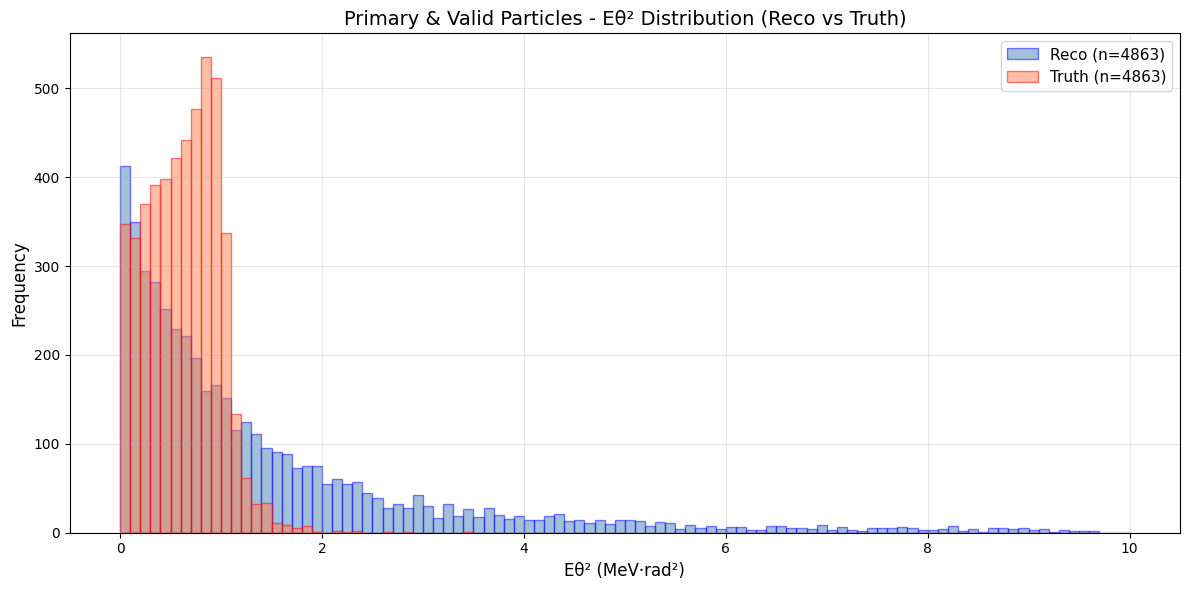

RECO:
  Total particles: 4863
  Mean: 30.25 MeV·rad²
  Median: 0.92 MeV·rad²
  Std: 524.20 MeV·rad²

TRUTH:
  Total particles: 4863
  Mean: 0.63 MeV·rad²
  Median: 0.64 MeV·rad²
  Std: 0.35 MeV·rad²


In [37]:
import matplotlib.pyplot as plt
import numpy as np

etheta2_list_reco = []
etheta2_list_truth = []

for i in indices_true_1e:
    if i not in indices_after_topo_cut:
        continue
    for particle_dict in reco_particle_info[i]:
        if particle_dict['primary'] and particle_dict['valid']:
            ke = particle_dict['reco_ke']
            angle = particle_dict['angle_wrt_beam']
            angle_rad = angle * np.pi / 180.0
            etheta2 = ke * (angle_rad ** 2)
            etheta2_list_reco.append(etheta2)

for i in indices_true_1e:
    if i not in indices_after_topo_cut:
        continue
    for particle_dict in true_particle_info[i]:
        if particle_dict['primary'] and particle_dict['valid']:
            ke = particle_dict['reco_ke']
            angle = particle_dict['angle_wrt_beam']
            angle_rad = angle * np.pi / 180.0
            etheta2 = ke * (angle_rad ** 2)
            etheta2_list_truth.append(etheta2)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.hist(etheta2_list_reco, bins=100, range=(0, 10), edgecolor='blue', alpha=0.5, 
        color='steelblue', label=f'Reco (n={len(etheta2_list_reco)})')
ax.hist(etheta2_list_truth, bins=100, range=(0, 10), edgecolor='red', alpha=0.5, 
        color='coral', label=f'Truth (n={len(etheta2_list_truth)})')

ax.set_xlabel('Eθ² (MeV·rad²)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Primary & Valid Particles - Eθ² Distribution (Reco vs Truth)', fontsize=14)
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=" * 60)
print("RECO:")
print(f"  Total particles: {len(etheta2_list_reco)}")
print(f"  Mean: {np.mean(etheta2_list_reco):.2f} MeV·rad²")
print(f"  Median: {np.median(etheta2_list_reco):.2f} MeV·rad²")
print(f"  Std: {np.std(etheta2_list_reco):.2f} MeV·rad²")

print("\nTRUTH:")
print(f"  Total particles: {len(etheta2_list_truth)}")
print(f"  Mean: {np.mean(etheta2_list_truth):.2f} MeV·rad²")
print(f"  Median: {np.median(etheta2_list_truth):.2f} MeV·rad²")
print(f"  Std: {np.std(etheta2_list_truth):.2f} MeV·rad²")
print("=" * 60)


In [38]:
# Export Eθ² distribution data to CSV
import pandas as pd

# Export Eθ² data
etheta2_data = pd.DataFrame({
    'etheta2_reco': etheta2_list_reco,
})
etheta2_data.to_csv(f'{data_dir}/nuone_etheta2_reco.csv', index=False)

etheta2_data_truth = pd.DataFrame({
    'etheta2_truth': etheta2_list_truth,
})
etheta2_data_truth.to_csv(f'{data_dir}/nuone_etheta2_truth.csv', index=False)

print(f"Exported Eθ² data to {data_dir}")
print(f"  - nuone_etheta2_reco.csv: {len(etheta2_list_reco)} entries")
print(f"  - nuone_etheta2_truth.csv: {len(etheta2_list_truth)} entries")

Exported Eθ² data to ./data
  - nuone_etheta2_reco.csv: 4863 entries
  - nuone_etheta2_truth.csv: 4863 entries


## Cut

In [39]:
# Cut 5: Eθ² cut
import numpy as np

indices_after_etheta2_cut = []

# Counters for warnings
warning_zero_particles = 0
warning_multiple_particles = 0
warning_etheta2_out_of_range = 0

if ENABLE_ETHETA2_CUT:
    for i in indices_after_dedx_cut:
        particle_list = reco_particle_info[i]
        
        # Count primary and valid particles
        num_primary_valid_particles = sum(1 for p in particle_list if p['primary'] and p['valid'])
        
        # Issue warnings if not exactly 1 primary valid particle
        if num_primary_valid_particles == 0:
            print(f"Warning: Interaction {i} has 0 primary & valid particles")
            warning_zero_particles += 1
            indices_after_etheta2_cut.append(i)
            continue
        elif num_primary_valid_particles > 1:
            print(f"Warning: Interaction {i} has {num_primary_valid_particles} primary & valid particles")
            warning_multiple_particles += 1
            indices_after_etheta2_cut.append(i)
            continue
        
        # Find the primary and valid particle
        for particle_dict in particle_list:
            if particle_dict['primary'] and particle_dict['valid']:
                ke = particle_dict['reco_ke']  # MeV
                angle = particle_dict['angle_wrt_beam']  # degrees
                angle_rad = angle * np.pi / 180.0  # convert to radians
                etheta2 = ke * (angle_rad ** 2)  # MeV·rad²
                
                # Apply Eθ² cut
                if etheta2 < ETHETA2_CUT_MAX:
                    indices_after_etheta2_cut.append(i)
                else:
                    warning_etheta2_out_of_range += 1
                break

    # Print summary
    print("\n" + "=" * 60)
    print("Eθ² Cut: ENABLED")
    print("=" * 60)
    print(f"After last cut: {len(indices_after_dedx_cut)} interactions")
    print(f"Pass Eθ² cut: {len(indices_after_etheta2_cut)} / {count} interactions")
    print(f"Efficiency: {len(indices_after_etheta2_cut)/count*100:.2f}%")
    print(f"\nWarnings:")
    print(f"  Interactions with 0 primary & valid particles: {warning_zero_particles}")
    print(f"  Interactions with >1 primary & valid particles: {warning_multiple_particles}")
    print("=" * 60)
else:
    # If cut is disabled, pass all interactions from previous cut
    indices_after_etheta2_cut = indices_after_dedx_cut.copy()
    print("\n" + "=" * 60)
    print("Eθ² Cut: DISABLED")
    print(f"All {len(indices_after_etheta2_cut)} interactions passed")
    print("=" * 60)

indices_of_remaining_nuone = indices_after_etheta2_cut.copy()


Eθ² Cut: ENABLED
After last cut: 2781 interactions
Pass Eθ² cut: 2419 / 6067 interactions
Efficiency: 39.87%

Warnings:
  Interactions with 0 primary & valid particles: 0
  Interactions with >1 primary & valid particles: 0


# Cut 6: Kinetic Energy

## Distribution

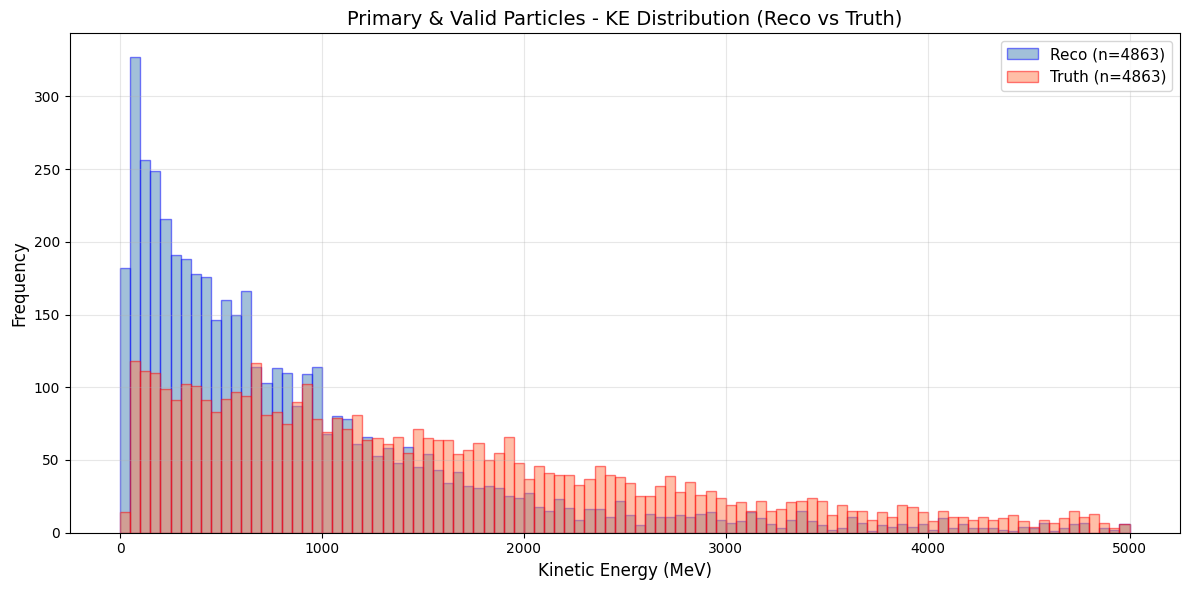

RECO:
  Total particles: 4863
  Mean: 955.90 MeV
  Median: 602.71 MeV
  Std: 1102.11 MeV

TRUTH:
  Total particles: 4863
  Mean: 2367.84 MeV
  Median: 1441.48 MeV
  Std: 3167.62 MeV


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

ke_list_reco = []
ke_list_truth = []

for i in indices_true_1e:
    if i not in indices_after_topo_cut:
        continue
    for particle_dict in reco_particle_info[i]:
        if particle_dict['primary'] and particle_dict['valid']:
            ke = particle_dict['reco_ke']
            ke_list_reco.append(ke)

for i in indices_true_1e:
    if i not in indices_after_topo_cut:
        continue
    for particle_dict in true_particle_info[i]:
        if particle_dict['primary'] and particle_dict['valid']:
            ke = particle_dict['reco_ke']
            ke_list_truth.append(ke)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.hist(ke_list_reco, bins=100, range=(0, 5000), edgecolor='blue', alpha=0.5, 
        color='steelblue', label=f'Reco (n={len(ke_list_reco)})')
ax.hist(ke_list_truth, bins=100, range=(0, 5000), edgecolor='red', alpha=0.5, 
        color='coral', label=f'Truth (n={len(ke_list_truth)})')

ax.set_xlabel('Kinetic Energy (MeV)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Primary & Valid Particles - KE Distribution (Reco vs Truth)', fontsize=14)
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=" * 60)
print("RECO:")
print(f"  Total particles: {len(ke_list_reco)}")
print(f"  Mean: {np.mean(ke_list_reco):.2f} MeV")
print(f"  Median: {np.median(ke_list_reco):.2f} MeV")
print(f"  Std: {np.std(ke_list_reco):.2f} MeV")

print("\nTRUTH:")
print(f"  Total particles: {len(ke_list_truth)}")
print(f"  Mean: {np.mean(ke_list_truth):.2f} MeV")
print(f"  Median: {np.median(ke_list_truth):.2f} MeV")
print(f"  Std: {np.std(ke_list_truth):.2f} MeV")
print("=" * 60)


In [ ]:
# Export KE distribution data to CSV
import pandas as pd

# Export KE data
ke_data = pd.DataFrame({
    'ke_reco': ke_list_reco,
})
ke_data.to_csv(f'{data_dir}/nuone_ke_reco.csv', index=False)

ke_data_truth = pd.DataFrame({
    'ke_truth': ke_list_truth,
})
ke_data_truth.to_csv(f'{data_dir}/nuone_ke_truth.csv', index=False)

print(f"Exported KE data to {data_dir}")
print(f"  - nuone_ke_reco.csv: {len(ke_list_reco)} entries")
print(f"  - nuone_ke_truth.csv: {len(ke_list_truth)} entries")

Exported KE data to ./data
  - nuone_ke_reco.csv: 4863 entries
  - nuone_ke_truth.csv: 4863 entries


## Cut

In [ ]:
# Cut 6: KE cut
import numpy as np

indices_after_ke_cut = []

# Counters for warnings
warning_zero_particles = 0
warning_multiple_particles = 0

if ENABLE_KE_CUT:
    for i in indices_after_etheta2_cut:
        particle_list = reco_particle_info[i]
        
        # Count primary and valid particles
        num_primary_valid_particles = sum(1 for p in particle_list if p['primary'] and p['valid'])
        
        # Issue warnings if not exactly 1 primary valid particle
        if num_primary_valid_particles == 0:
            print(f"Warning: Interaction {i} has 0 primary & valid particles")
            warning_zero_particles += 1
            indices_after_ke_cut.append(i)
            continue
        elif num_primary_valid_particles > 1:
            print(f"Warning: Interaction {i} has {num_primary_valid_particles} primary & valid particles")
            warning_multiple_particles += 1
            indices_after_ke_cut.append(i)
            continue
        
        # Find the primary and valid particle
        for particle_dict in particle_list:
            if particle_dict['primary'] and particle_dict['valid']:
                ke = particle_dict['reco_ke']  # MeV
                
                # Apply KE cut
                if ke > KE_CUT_MIN:
                    indices_after_ke_cut.append(i)
                break

    # Print summary
    print("\n" + "=" * 60)
    print("KE Cut: ENABLED")
    print("=" * 60)
    print(f"After last cut: {len(indices_after_etheta2_cut)} interactions")
    print(f"Pass KE cut: {len(indices_after_ke_cut)} / {count} interactions")
    print(f"Efficiency: {len(indices_after_ke_cut)/count*100:.2f}%")
    print(f"\nWarnings:")
    print(f"  Interactions with 0 primary & valid particles: {warning_zero_particles}")
    print(f"  Interactions with >1 primary & valid particles: {warning_multiple_particles}")
    print("=" * 60)
else:
    # If cut is disabled, pass all interactions from previous cut
    indices_after_ke_cut = indices_after_etheta2_cut.copy()
    print("\n" + "=" * 60)
    print("KE Cut: DISABLED")
    print(f"All {len(indices_after_ke_cut)} interactions passed")
    print("=" * 60)

indices_of_remaining_nuone = indices_after_ke_cut.copy()


KE Cut: ENABLED
After last cut: 2419 interactions
Pass KE cut: 2146 / 6067 interactions
Efficiency: 35.37%

Warnings:
  Interactions with 0 primary & valid particles: 0
  Interactions with >1 primary & valid particles: 0


# Cut 7: PCA Analysis

## Distribution

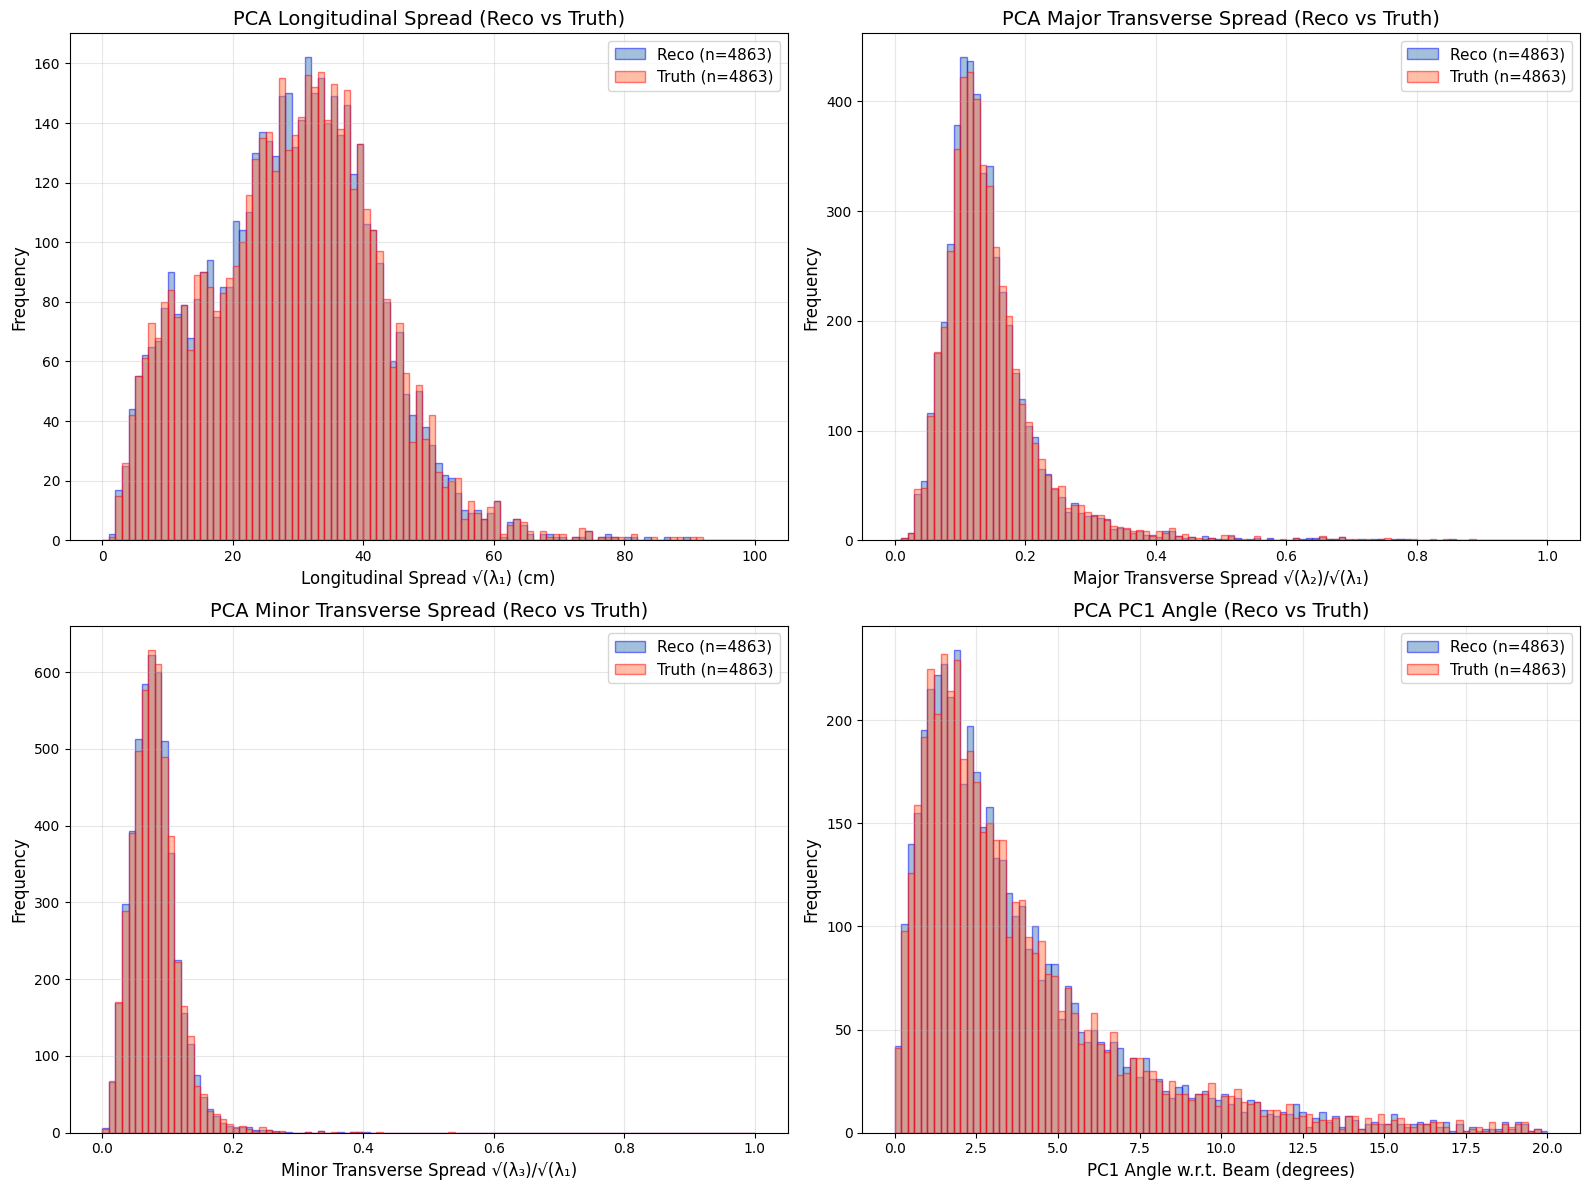

RECO PCA Statistics:
Longitudinal √(λ₁) (cm):
  Mean: 28.88, Median: 29.41, Std: 12.86

Major Transverse √(λ₂)/√(λ₁):
  Mean: 0.144, Median: 0.128, Std: 0.077

Minor Transverse √(λ₃)/√(λ₁):
  Mean: 0.080, Median: 0.077, Std: 0.036

PC1 Angle (degrees):
  Mean: 4.34, Median: 2.80, Std: 5.64

TRUTH PCA Statistics:
Longitudinal √(λ₁) (cm):
  Mean: 29.08, Median: 29.58, Std: 13.04

Major Transverse √(λ₂)/√(λ₁):
  Mean: 0.147, Median: 0.129, Std: 0.081

Minor Transverse √(λ₃)/√(λ₁):
  Mean: 0.080, Median: 0.077, Std: 0.037

PC1 Angle (degrees):
  Mean: 4.48, Median: 2.84, Std: 6.04


In [ ]:
# Extract PCA features for interactions after topology cut
import matplotlib.pyplot as plt
import numpy as np

# Lists for PCA features (reco)
longitudinal_reco = []  # sqrt(λ1)
transverse_major_reco = []  # sqrt(λ2)/sqrt(λ1)
transverse_minor_reco = []  # sqrt(λ3)/sqrt(λ1)
pc1_angle_reco = []  # angle between PC1 and beam direction

# Lists for PCA features (truth)
longitudinal_truth = []
transverse_major_truth = []
transverse_minor_truth = []
pc1_angle_truth = []

# Collect reco PCA features
for i in indices_true_1e:
    if i not in indices_after_topo_cut:
        continue
    pca_vars = reco_pca_variables[i]
    
    # Skip if reco is empty
    if pca_vars == '':
        continue
    
    eigenvalues = pca_vars['eigenvalues']
    angle = pca_vars['angle_wrt_beam']
    
    # Skip invalid PCA results
    if eigenvalues[0] < 0:
        continue
    
    # Calculate longitudinal spread: sqrt(λ1)
    long_spread = np.sqrt(eigenvalues[0])
    longitudinal_reco.append(long_spread)
    
    # Calculate transverse spreads (ratios)
    if eigenvalues[0] > 0:
        trans_major = np.sqrt(eigenvalues[1]) / np.sqrt(eigenvalues[0])
        trans_minor = np.sqrt(eigenvalues[2]) / np.sqrt(eigenvalues[0])
        transverse_major_reco.append(trans_major)
        transverse_minor_reco.append(trans_minor)
    
    # Store PC1 angle
    pc1_angle_reco.append(angle)

# Collect truth PCA features
for i in indices_true_1e:
    if i not in indices_after_topo_cut:
        continue
    pca_vars = true_pca_variables[i]
    
    if pca_vars == '':
        continue
    
    eigenvalues = pca_vars['eigenvalues']
    angle = pca_vars['angle_wrt_beam']
    
    # Skip invalid PCA results
    if eigenvalues[0] < 0:
        continue
    
    # Calculate longitudinal spread: sqrt(λ1)
    long_spread = np.sqrt(eigenvalues[0])
    longitudinal_truth.append(long_spread)
    
    # Calculate transverse spreads (ratios)
    if eigenvalues[0] > 0:
        trans_major = np.sqrt(eigenvalues[1]) / np.sqrt(eigenvalues[0])
        trans_minor = np.sqrt(eigenvalues[2]) / np.sqrt(eigenvalues[0])
        transverse_major_truth.append(trans_major)
        transverse_minor_truth.append(trans_minor)
    
    # Store PC1 angle
    pc1_angle_truth.append(angle)

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Longitudinal spread (sqrt(λ1))
ax = axes[0, 0]
ax.hist(longitudinal_reco, bins=100, range=(0, 100), edgecolor='blue', alpha=0.5, 
        color='steelblue', label=f'Reco (n={len(longitudinal_reco)})')
ax.hist(longitudinal_truth, bins=100, range=(0, 100), edgecolor='red', alpha=0.5, 
        color='coral', label=f'Truth (n={len(longitudinal_truth)})')
ax.set_xlabel('Longitudinal Spread √(λ₁) (cm)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('PCA Longitudinal Spread (Reco vs Truth)', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Plot 2: Major transverse spread (sqrt(λ2)/sqrt(λ1))
ax = axes[0, 1]
ax.hist(transverse_major_reco, bins=100, range=(0, 1), edgecolor='blue', alpha=0.5, 
        color='steelblue', label=f'Reco (n={len(transverse_major_reco)})')
ax.hist(transverse_major_truth, bins=100, range=(0, 1), edgecolor='red', alpha=0.5, 
        color='coral', label=f'Truth (n={len(transverse_major_truth)})')
ax.set_xlabel('Major Transverse Spread √(λ₂)/√(λ₁)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('PCA Major Transverse Spread (Reco vs Truth)', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Plot 3: Minor transverse spread (sqrt(λ3)/sqrt(λ1))
ax = axes[1, 0]
ax.hist(transverse_minor_reco, bins=100, range=(0, 1), edgecolor='blue', alpha=0.5, 
        color='steelblue', label=f'Reco (n={len(transverse_minor_reco)})')
ax.hist(transverse_minor_truth, bins=100, range=(0, 1), edgecolor='red', alpha=0.5, 
        color='coral', label=f'Truth (n={len(transverse_minor_truth)})')
ax.set_xlabel('Minor Transverse Spread √(λ₃)/√(λ₁)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('PCA Minor Transverse Spread (Reco vs Truth)', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Plot 4: PC1 angle with beam
ax = axes[1, 1]
ax.hist(pc1_angle_reco, bins=100, range=(0, 20), edgecolor='blue', alpha=0.5, 
        color='steelblue', label=f'Reco (n={len(pc1_angle_reco)})')
ax.hist(pc1_angle_truth, bins=100, range=(0, 20), edgecolor='red', alpha=0.5, 
        color='coral', label=f'Truth (n={len(pc1_angle_truth)})')
ax.set_xlabel('PC1 Angle w.r.t. Beam (degrees)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('PCA PC1 Angle (Reco vs Truth)', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("=" * 60)
print("RECO PCA Statistics:")
print("=" * 60)
print(f"Longitudinal √(λ₁) (cm):")
print(f"  Mean: {np.mean(longitudinal_reco):.2f}, Median: {np.median(longitudinal_reco):.2f}, Std: {np.std(longitudinal_reco):.2f}")
print(f"\nMajor Transverse √(λ₂)/√(λ₁):")
print(f"  Mean: {np.mean(transverse_major_reco):.3f}, Median: {np.median(transverse_major_reco):.3f}, Std: {np.std(transverse_major_reco):.3f}")
print(f"\nMinor Transverse √(λ₃)/√(λ₁):")
print(f"  Mean: {np.mean(transverse_minor_reco):.3f}, Median: {np.median(transverse_minor_reco):.3f}, Std: {np.std(transverse_minor_reco):.3f}")
print(f"\nPC1 Angle (degrees):")
print(f"  Mean: {np.mean(pc1_angle_reco):.2f}, Median: {np.median(pc1_angle_reco):.2f}, Std: {np.std(pc1_angle_reco):.2f}")

print("\n" + "=" * 60)
print("TRUTH PCA Statistics:")
print("=" * 60)
print(f"Longitudinal √(λ₁) (cm):")
print(f"  Mean: {np.mean(longitudinal_truth):.2f}, Median: {np.median(longitudinal_truth):.2f}, Std: {np.std(longitudinal_truth):.2f}")
print(f"\nMajor Transverse √(λ₂)/√(λ₁):")
print(f"  Mean: {np.mean(transverse_major_truth):.3f}, Median: {np.median(transverse_major_truth):.3f}, Std: {np.std(transverse_major_truth):.3f}")
print(f"\nMinor Transverse √(λ₃)/√(λ₁):")
print(f"  Mean: {np.mean(transverse_minor_truth):.3f}, Median: {np.median(transverse_minor_truth):.3f}, Std: {np.std(transverse_minor_truth):.3f}")
print(f"\nPC1 Angle (degrees):")
print(f"  Mean: {np.mean(pc1_angle_truth):.2f}, Median: {np.median(pc1_angle_truth):.2f}, Std: {np.std(pc1_angle_truth):.2f}")
print("=" * 60)

In [ ]:
# Export PCA distribution data to CSV
import pandas as pd

# Export PCA data
pca_data_reco = pd.DataFrame({
    'longitudinal_reco': longitudinal_reco,
    'transverse_major_reco': transverse_major_reco,
    'transverse_minor_reco': transverse_minor_reco,
    'pc1_angle_reco': pc1_angle_reco,
})
pca_data_reco.to_csv(f'{data_dir}/nuone_pca_reco.csv', index=False)

pca_data_truth = pd.DataFrame({
    'longitudinal_truth': longitudinal_truth,
    'transverse_major_truth': transverse_major_truth,
    'transverse_minor_truth': transverse_minor_truth,
    'pc1_angle_truth': pc1_angle_truth,
})
pca_data_truth.to_csv(f'{data_dir}/nuone_pca_truth.csv', index=False)

print(f"Exported PCA data to {data_dir}")
print(f"  - nuone_pca_reco.csv: {len(longitudinal_reco)} entries")
print(f"  - nuone_pca_truth.csv: {len(longitudinal_truth)} entries")

Exported PCA data to ./data
  - nuone_pca_reco.csv: 4863 entries
  - nuone_pca_truth.csv: 4863 entries


## Cut

In [ ]:
# Cut 7: PCA cuts
import numpy as np

indices_after_pca_cut = []

# Counters for warnings and failures
fail_longitudinal = 0
fail_transverse_major = 0
fail_transverse_minor = 0
fail_pc1_angle = 0

if ENABLE_PCA_CUT:
    for i in indices_after_ke_cut:
        # Get PCA variables for this interaction
        pca_vars = reco_pca_variables[i]
        
        # Check if pca_vars is a dictionary (new format)
        if isinstance(pca_vars, dict):
            eigenvalues = pca_vars['eigenvalues']
            pc1_angle = pca_vars['angle_wrt_beam']
        else:
            # Old format: tuple (eigenvalues, eigenvectors, centroid)
            eigenvalues, eigenvectors, centroid = pca_vars
            # Calculate angle manually
            th = -0.101  # radians
            beam_direction = np.array([0, np.sin(th), np.cos(th)])
            pc1 = eigenvectors[:, 0]
            cos_angle = np.abs(np.dot(pc1, beam_direction))
            cos_angle = np.clip(cos_angle, -1.0, 1.0)
            pc1_angle = np.arccos(cos_angle) * 180.0 / np.pi
        
        
        # Calculate PCA features
        # 1. Longitudinal spread: sqrt(λ1)
        longitudinal_spread = np.sqrt(eigenvalues[0])
        
        # 2. Major transverse spread: sqrt(λ2)/sqrt(λ1)
        transverse_major_spread = np.sqrt(eigenvalues[1]) / np.sqrt(eigenvalues[0])
        
        # 3. Minor transverse spread: sqrt(λ3)/sqrt(λ1)
        transverse_minor_spread = np.sqrt(eigenvalues[2]) / np.sqrt(eigenvalues[0])
        
        # Apply PCA cuts
        pass_all_cuts = True
        
        # Cut 1: Longitudinal spread
        if not (PCA_LONGITUDINAL_MIN < longitudinal_spread < PCA_LONGITUDINAL_MAX):
            fail_longitudinal += 1
            pass_all_cuts = False
        
        # Cut 2: Major transverse spread
        if not (PCA_TRANSVERSE_MAJOR_MIN < transverse_major_spread < PCA_TRANSVERSE_MAJOR_MAX):
            fail_transverse_major += 1
            pass_all_cuts = False
        
        # Cut 3: Minor transverse spread
        if not (PCA_TRANSVERSE_MINOR_MIN < transverse_minor_spread < PCA_TRANSVERSE_MINOR_MAX):
            fail_transverse_minor += 1
            pass_all_cuts = False
        
        # Cut 4: PC1 angle (only if enabled, i.e., < 90 degrees)
        if PCA_PC1_ANGLE_MAX < 90 and pc1_angle > PCA_PC1_ANGLE_MAX:
            fail_pc1_angle += 1
            pass_all_cuts = False
        
        if pass_all_cuts:
            indices_after_pca_cut.append(i)

    # Print summary
    print("\n" + "=" * 60)
    print("PCA Cut: ENABLED")
    print("=" * 60)
    print(f"After last cut: {len(indices_after_ke_cut)} interactions")
    print(f"Pass PCA cuts: {len(indices_after_pca_cut)} / {count} interactions")
    print(f"Efficiency: {len(indices_after_pca_cut)/count*100:.2f}%")
    print(f"\nCut Failures:")
    print(f"  Longitudinal spread out of range: {fail_longitudinal}")
    print(f"  Major transverse spread out of range: {fail_transverse_major}")
    print(f"  Minor transverse spread out of range: {fail_transverse_minor}")
    print(f"  PC1 angle out of range: {fail_pc1_angle}")
    print("=" * 60)
else:
    # If cut is disabled, pass all interactions from previous cut
    indices_after_pca_cut = indices_after_ke_cut.copy()
    print("\n" + "=" * 60)
    print("PCA Cut: DISABLED")
    print(f"All {len(indices_after_pca_cut)} interactions passed")
    print("=" * 60)

indices_of_remaining_nuone = indices_after_pca_cut.copy()


PCA Cut: ENABLED
After last cut: 2146 interactions
Pass PCA cuts: 2139 / 6067 interactions
Efficiency: 35.26%

Cut Failures:
  Longitudinal spread out of range: 0
  Major transverse spread out of range: 6
  Minor transverse spread out of range: 2
  PC1 angle out of range: 0


# Evaluation of angular resolutionm

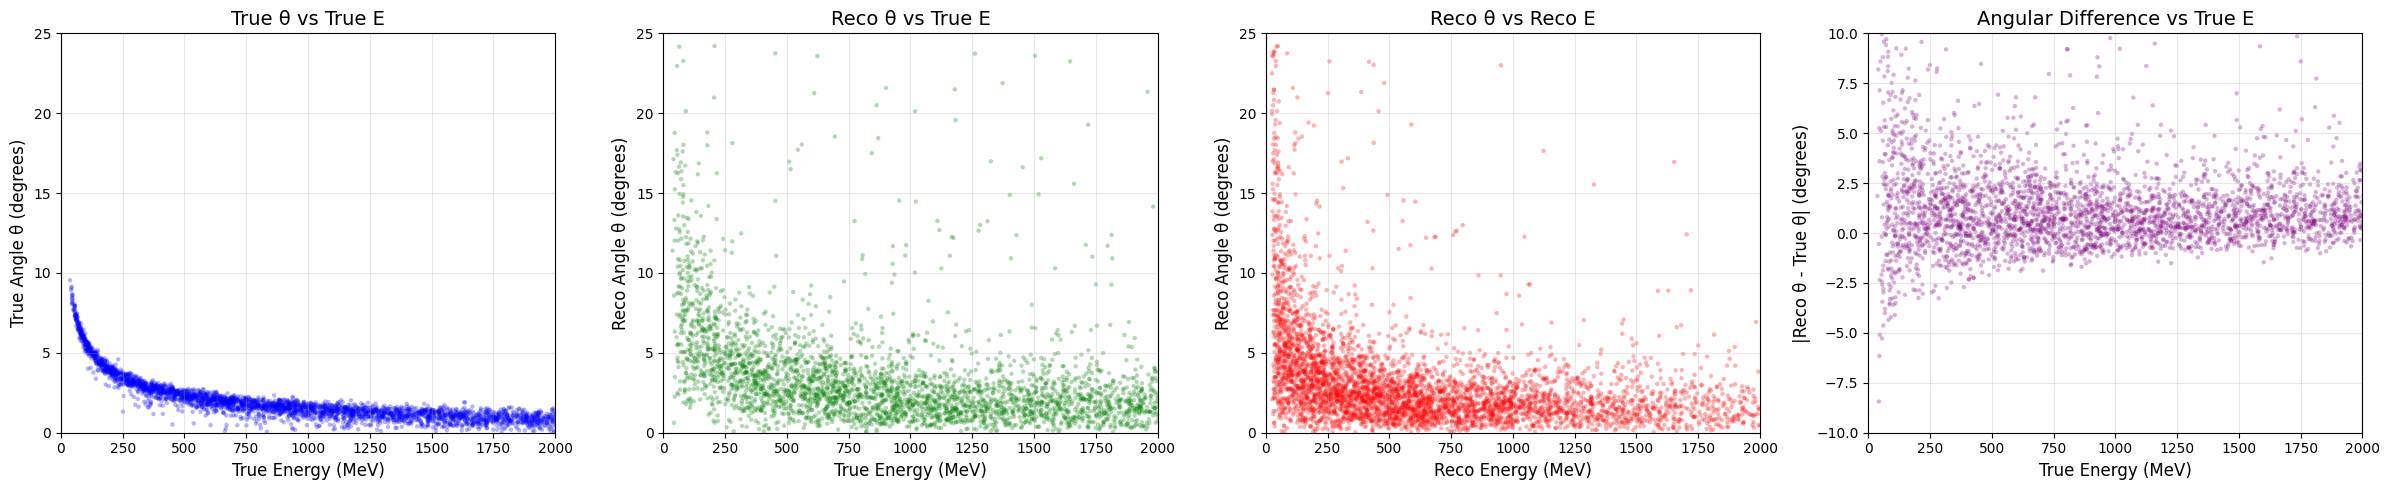

Theta-E Scatter Plot Statistics

Plot 1 - True θ vs True E:
  Number of particles: 4863
  True E range: [37.28, 48373.62] MeV
  True θ range: [0.02, 9.54]°

Plot 2 - Reco θ vs True E:
  Number of matched particles: 4863
  True E range: [37.28, 48373.62] MeV
  Reco θ range: [0.03, 169.14]°

Plot 3 - Reco θ vs Reco E:
  Number of particles: 4863
  Reco E range: [25.13, 9095.81] MeV
  Reco θ range: [0.03, 169.14]°

Plot 4 - |Reco θ - True θ| vs True E:
  Number of matched particles: 4863
  True E range: [37.28, 48373.62] MeV
  |Δθ| range: [-8.44, 166.58]°
  Mean |Δθ|: 2.61°
  Median |Δθ|: 1.01°
  Std |Δθ|: 9.03°


In [40]:
# Plot theta vs E scatter plots: true theta vs true E, reco theta vs true E, reco theta vs reco E
# Plus: |Reco theta - True theta| vs E scatter plot
import matplotlib.pyplot as plt
import numpy as np

# Set x and y axis ranges for theta-E plots
THETA_X_RANGE = [0, 2000]  # Energy range (MeV)
THETA_Y_RANGE = [0, 25]    # Angle range (degrees)
DELTA_THETA_Y_RANGE = [-10, 10]  # Angle difference range (degrees)

# Collect data for theta-E scatter plots
true_ke_for_theta = []
true_theta_list = []
reco_ke_for_theta = []
reco_theta_list = []

# Iterate through matched pairs (reco and truth)
for i in indices_after_topo_cut:
    # Get truth particle info
    for particle_dict in true_particle_info[i]:
        if particle_dict['primary'] and particle_dict['valid']:
            ke_truth = particle_dict['reco_ke']
            angle_truth = particle_dict['angle_wrt_beam']
            
            true_ke_for_theta.append(ke_truth)
            true_theta_list.append(angle_truth)
    
    # Get reco particle info
    for particle_dict in reco_particle_info[i]:
        if particle_dict['primary'] and particle_dict['valid']:
            ke_reco = particle_dict['reco_ke']
            angle_reco = particle_dict['angle_wrt_beam']
            
            reco_ke_for_theta.append(ke_reco)
            reco_theta_list.append(angle_reco)

# Match reco and truth particles for the middle plot
reco_theta_matched = []
true_ke_for_theta_matched = []
for i in indices_after_topo_cut:
    # Take the first primary valid particle from each
    truth_ke = None
    for particle_dict in true_particle_info[i]:
        if particle_dict['primary'] and particle_dict['valid']:
            truth_ke = particle_dict['reco_ke']
            break
    
    reco_theta = None
    for particle_dict in reco_particle_info[i]:
        if particle_dict['primary'] and particle_dict['valid']:
            reco_theta = particle_dict['angle_wrt_beam']
            break
    
    if truth_ke is not None and reco_theta is not None:
        true_ke_for_theta_matched.append(truth_ke)
        reco_theta_matched.append(reco_theta)

# Collect data for |Reco theta - True theta| vs E
delta_theta_list = []
energy_for_delta_theta = []

for i in indices_after_topo_cut:
    # Get first primary valid particle from truth
    true_theta = None
    true_ke = None
    for particle_dict in true_particle_info[i]:
        if particle_dict['primary'] and particle_dict['valid']:
            true_theta = particle_dict['angle_wrt_beam']
            true_ke = particle_dict['reco_ke']
            break
    
    # Get first primary valid particle from reco
    reco_theta = None
    for particle_dict in reco_particle_info[i]:
        if particle_dict['primary'] and particle_dict['valid']:
            reco_theta = particle_dict['angle_wrt_beam']
            break
    
    # Calculate |Reco theta - True theta|
    if true_theta is not None and reco_theta is not None and true_ke is not None:
        delta_theta = ((reco_theta - true_theta))
        delta_theta_list.append(delta_theta)
        energy_for_delta_theta.append(true_ke)

# Create figure with 4 subplots for theta-E scatter plots
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

# Scatter Plot 1: true theta vs true E
axes[0].scatter(true_ke_for_theta, true_theta_list, alpha=0.3, s=10, c='blue', edgecolors='none')
axes[0].set_xlabel('True Energy (MeV)', fontsize=12)
axes[0].set_ylabel('True Angle θ (degrees)', fontsize=12)
axes[0].set_title('True θ vs True E', fontsize=14)
axes[0].set_xlim(THETA_X_RANGE)
axes[0].set_ylim(THETA_Y_RANGE)
axes[0].grid(True, alpha=0.3)

# Scatter Plot 2: reco theta vs true E
axes[1].scatter(true_ke_for_theta_matched, reco_theta_matched, alpha=0.3, s=10, c='green', edgecolors='none')
axes[1].set_xlabel('True Energy (MeV)', fontsize=12)
axes[1].set_ylabel('Reco Angle θ (degrees)', fontsize=12)
axes[1].set_title('Reco θ vs True E', fontsize=14)
axes[1].set_xlim(THETA_X_RANGE)
axes[1].set_ylim(THETA_Y_RANGE)
axes[1].grid(True, alpha=0.3)

# Scatter Plot 3: reco theta vs reco E
axes[2].scatter(reco_ke_for_theta, reco_theta_list, alpha=0.3, s=10, c='red', edgecolors='none')
axes[2].set_xlabel('Reco Energy (MeV)', fontsize=12)
axes[2].set_ylabel('Reco Angle θ (degrees)', fontsize=12)
axes[2].set_title('Reco θ vs Reco E', fontsize=14)
axes[2].set_xlim(THETA_X_RANGE)
axes[2].set_ylim(THETA_Y_RANGE)
axes[2].grid(True, alpha=0.3)

# Scatter Plot 4: |Reco theta - True theta| vs E
axes[3].scatter(energy_for_delta_theta, delta_theta_list, alpha=0.3, s=10, c='purple', edgecolors='none')
axes[3].set_xlabel('True Energy (MeV)', fontsize=12)
axes[3].set_ylabel('|Reco θ - True θ| (degrees)', fontsize=12)
axes[3].set_title('Angular Difference vs True E', fontsize=14)
axes[3].set_xlim(THETA_X_RANGE)
axes[3].set_ylim(DELTA_THETA_Y_RANGE)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("=" * 80)
print("Theta-E Scatter Plot Statistics")
print("=" * 80)
print(f"\nPlot 1 - True θ vs True E:")
print(f"  Number of particles: {len(true_ke_for_theta)}")
print(f"  True E range: [{min(true_ke_for_theta):.2f}, {max(true_ke_for_theta):.2f}] MeV")
print(f"  True θ range: [{min(true_theta_list):.2f}, {max(true_theta_list):.2f}]°")

print(f"\nPlot 2 - Reco θ vs True E:")
print(f"  Number of matched particles: {len(true_ke_for_theta_matched)}")
print(f"  True E range: [{min(true_ke_for_theta_matched):.2f}, {max(true_ke_for_theta_matched):.2f}] MeV")
print(f"  Reco θ range: [{min(reco_theta_matched):.2f}, {max(reco_theta_matched):.2f}]°")

print(f"\nPlot 3 - Reco θ vs Reco E:")
print(f"  Number of particles: {len(reco_ke_for_theta)}")
print(f"  Reco E range: [{min(reco_ke_for_theta):.2f}, {max(reco_ke_for_theta):.2f}] MeV")
print(f"  Reco θ range: [{min(reco_theta_list):.2f}, {max(reco_theta_list):.2f}]°")

print(f"\nPlot 4 - |Reco θ - True θ| vs True E:")
print(f"  Number of matched particles: {len(delta_theta_list)}")
print(f"  True E range: [{min(energy_for_delta_theta):.2f}, {max(energy_for_delta_theta):.2f}] MeV")
print(f"  |Δθ| range: [{min(delta_theta_list):.2f}, {max(delta_theta_list):.2f}]°")
print(f"  Mean |Δθ|: {np.mean(delta_theta_list):.2f}°")
print(f"  Median |Δθ|: {np.median(delta_theta_list):.2f}°")
print(f"  Std |Δθ|: {np.std(delta_theta_list):.2f}°")
print("=" * 80)

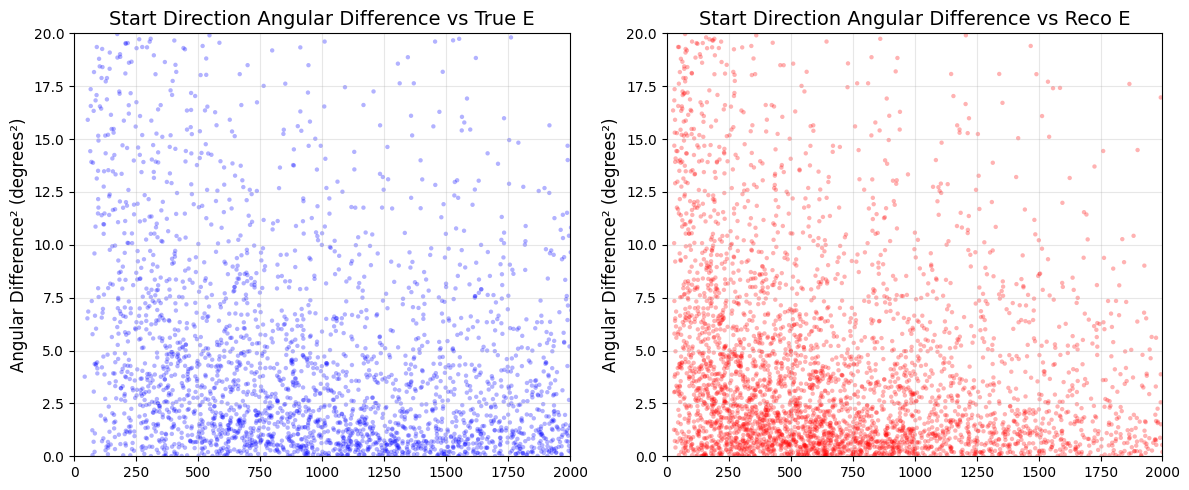

Start Direction Angular Difference² Statistics
Start Direction Angular Difference Statistics
Number of matched particles: 4863

True Energy range: [37.28, 48373.62] MeV

Angular Difference² (start_dir):
  Range: [0.00, 30306.58]°²
  Mean: 96.52°²
  Median: 3.46°²
  Std: 983.75°²


In [42]:
# Plot angular difference (from start_dir) vs Energy scatter plots
import matplotlib.pyplot as plt
import numpy as np

# Set axis ranges
START_DIR_X_RANGE = [0, 2000]  # Energy range (MeV)
START_DIR_Y_RANGE = [0, 20]   # Angular difference squared range (degrees^2)

# Collect data for start_dir angular difference analysis
true_energy_list = []
reco_energy_list = []
start_dir_angle_diff_squared_list = []

# Match reco and truth particles and calculate angular difference
for i in indices_after_topo_cut:
    # Get first primary valid particle from truth
    true_start_dir = None
    true_ke = None
    for particle_dict in true_particle_info[i]:
        if particle_dict['primary'] and particle_dict['valid']:
            true_start_dir = np.array(particle_dict['start_dir'])
            true_ke = particle_dict['reco_ke']
            break
    
    # Get first primary valid particle from reco
    reco_start_dir = None
    reco_ke = None
    for particle_dict in reco_particle_info[i]:
        if particle_dict['primary'] and particle_dict['valid']:
            reco_start_dir = np.array(particle_dict['start_dir'])
            reco_ke = particle_dict['reco_ke']
            break
    
    # Calculate angular difference between start directions
    if true_start_dir is not None and reco_start_dir is not None and true_ke is not None and reco_ke is not None:
        # Normalize vectors
        true_dir_normalized = true_start_dir / np.linalg.norm(true_start_dir)
        reco_dir_normalized = reco_start_dir / np.linalg.norm(reco_start_dir)
        
        # Calculate angle using dot product: cos(theta) = v1 · v2
        cos_angle = np.clip(np.dot(true_dir_normalized, reco_dir_normalized), -1.0, 1.0)
        angle_rad = np.arccos(cos_angle)
        angle_deg = np.degrees(angle_rad)
        angle_deg_squared = angle_deg ** 2  # Square the angular difference
        
        true_energy_list.append(true_ke)
        reco_energy_list.append(reco_ke)
        start_dir_angle_diff_squared_list.append(angle_deg_squared)

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Scatter Plot 1: Angular difference squared vs True E
axes[0].scatter(true_energy_list, start_dir_angle_diff_squared_list, alpha=0.3, s=10, c='blue', edgecolors='none')
axes[0].set_ylabel('Angular Difference² (degrees²)', fontsize=12)
axes[0].set_title('Start Direction Angular Difference² vs True E', fontsize=14)
axes[0].set_title('Start Direction Angular Difference vs True E', fontsize=14)
axes[0].set_xlim(START_DIR_X_RANGE)
axes[0].set_ylim(START_DIR_Y_RANGE)
axes[0].grid(True, alpha=0.3)
# Scatter Plot 2: Angular difference squared vs Reco E
axes[1].scatter(reco_energy_list, start_dir_angle_diff_squared_list, alpha=0.3, s=10, c='red', edgecolors='none')
axes[1].set_ylabel('Angular Difference² (degrees²)', fontsize=12)
axes[1].set_title('Start Direction Angular Difference² vs Reco E', fontsize=14)
axes[1].set_title('Start Direction Angular Difference vs Reco E', fontsize=14)
axes[1].set_xlim(START_DIR_X_RANGE)
axes[1].set_ylim(START_DIR_Y_RANGE)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("Start Direction Angular Difference² Statistics")
print("Start Direction Angular Difference Statistics")
print(f"Number of matched particles: {len(start_dir_angle_diff_squared_list)}")
print(f"\nTrue Energy range: [{min(true_energy_list):.2f}, {max(true_energy_list):.2f}] MeV")
print(f"\nAngular Difference² (start_dir):")
print(f"  Range: [{min(start_dir_angle_diff_squared_list):.2f}, {max(start_dir_angle_diff_squared_list):.2f}]°²")
print(f"  Mean: {np.mean(start_dir_angle_diff_squared_list):.2f}°²")
print(f"  Median: {np.median(start_dir_angle_diff_squared_list):.2f}°²")
print(f"  Std: {np.std(start_dir_angle_diff_squared_list):.2f}°²")
print("=" * 80)

Processing True Energy Bins
Energy bin [0, 200] MeV: N=353, Median=24.87°², x_max=86.97°²
Energy bin [200, 400] MeV: N=393, Median=6.42°², x_max=17.14°²
Energy bin [400, 600] MeV: N=363, Median=4.66°², x_max=14.67°²
Energy bin [600, 800] MeV: N=375, Median=3.54°², x_max=9.03°²
Energy bin [800, 1000] MeV: N=345, Median=3.48°², x_max=10.43°²
Energy bin [1000, 1200] MeV: N=300, Median=2.37°², x_max=8.51°²
Energy bin [1200, 1400] MeV: N=256, Median=2.09°², x_max=7.00°²
Energy bin [1400, 1600] MeV: N=255, Median=2.75°², x_max=8.57°²
Energy bin [1600, 1800] MeV: N=237, Median=2.70°², x_max=7.90°²
Energy bin [1800, 2000] MeV: N=219, Median=2.66°², x_max=7.89°²

Processing Reco Energy Bins
Energy bin [0, 200] MeV: N=1014, Median=13.95°², x_max=80.34°²
Energy bin [200, 400] MeV: N=773, Median=4.18°², x_max=12.27°²
Energy bin [400, 600] MeV: N=632, Median=3.09°², x_max=8.48°²
Energy bin [600, 800] MeV: N=496, Median=2.12°², x_max=6.28°²
Energy bin [800, 1000] MeV: N=420, Median=2.20°², x_max=6.5

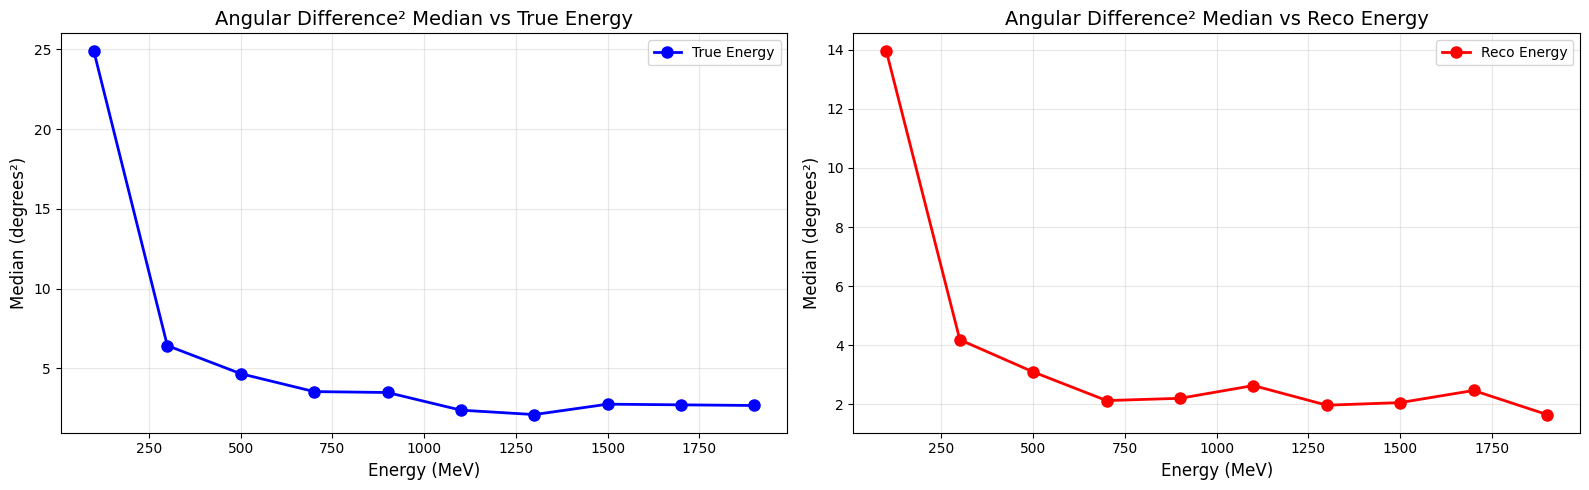

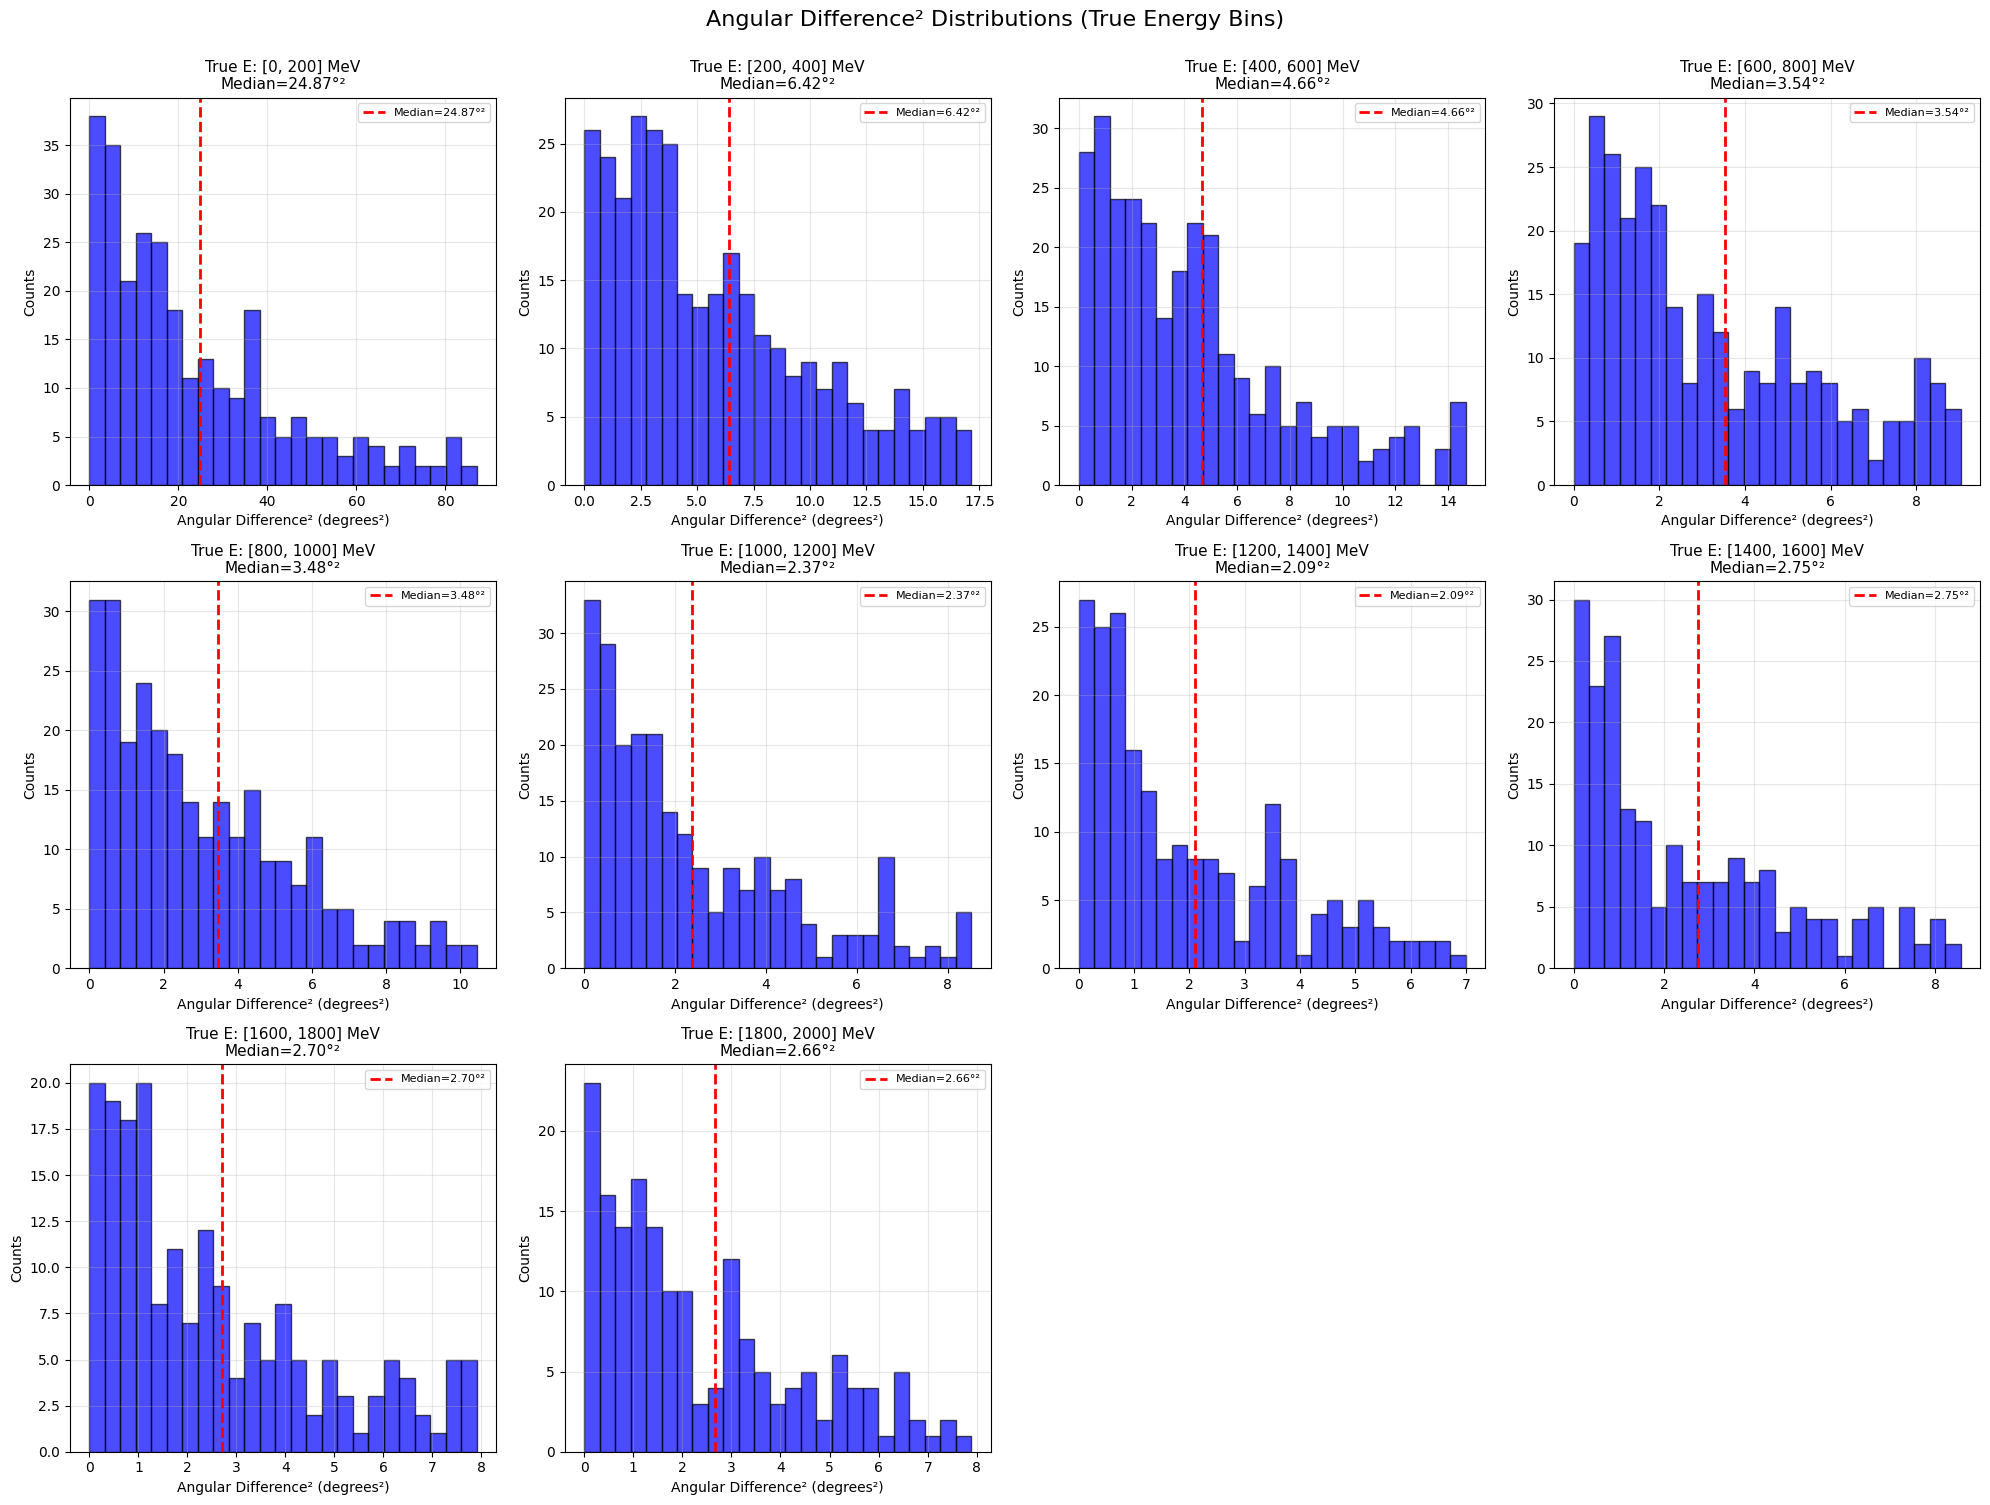

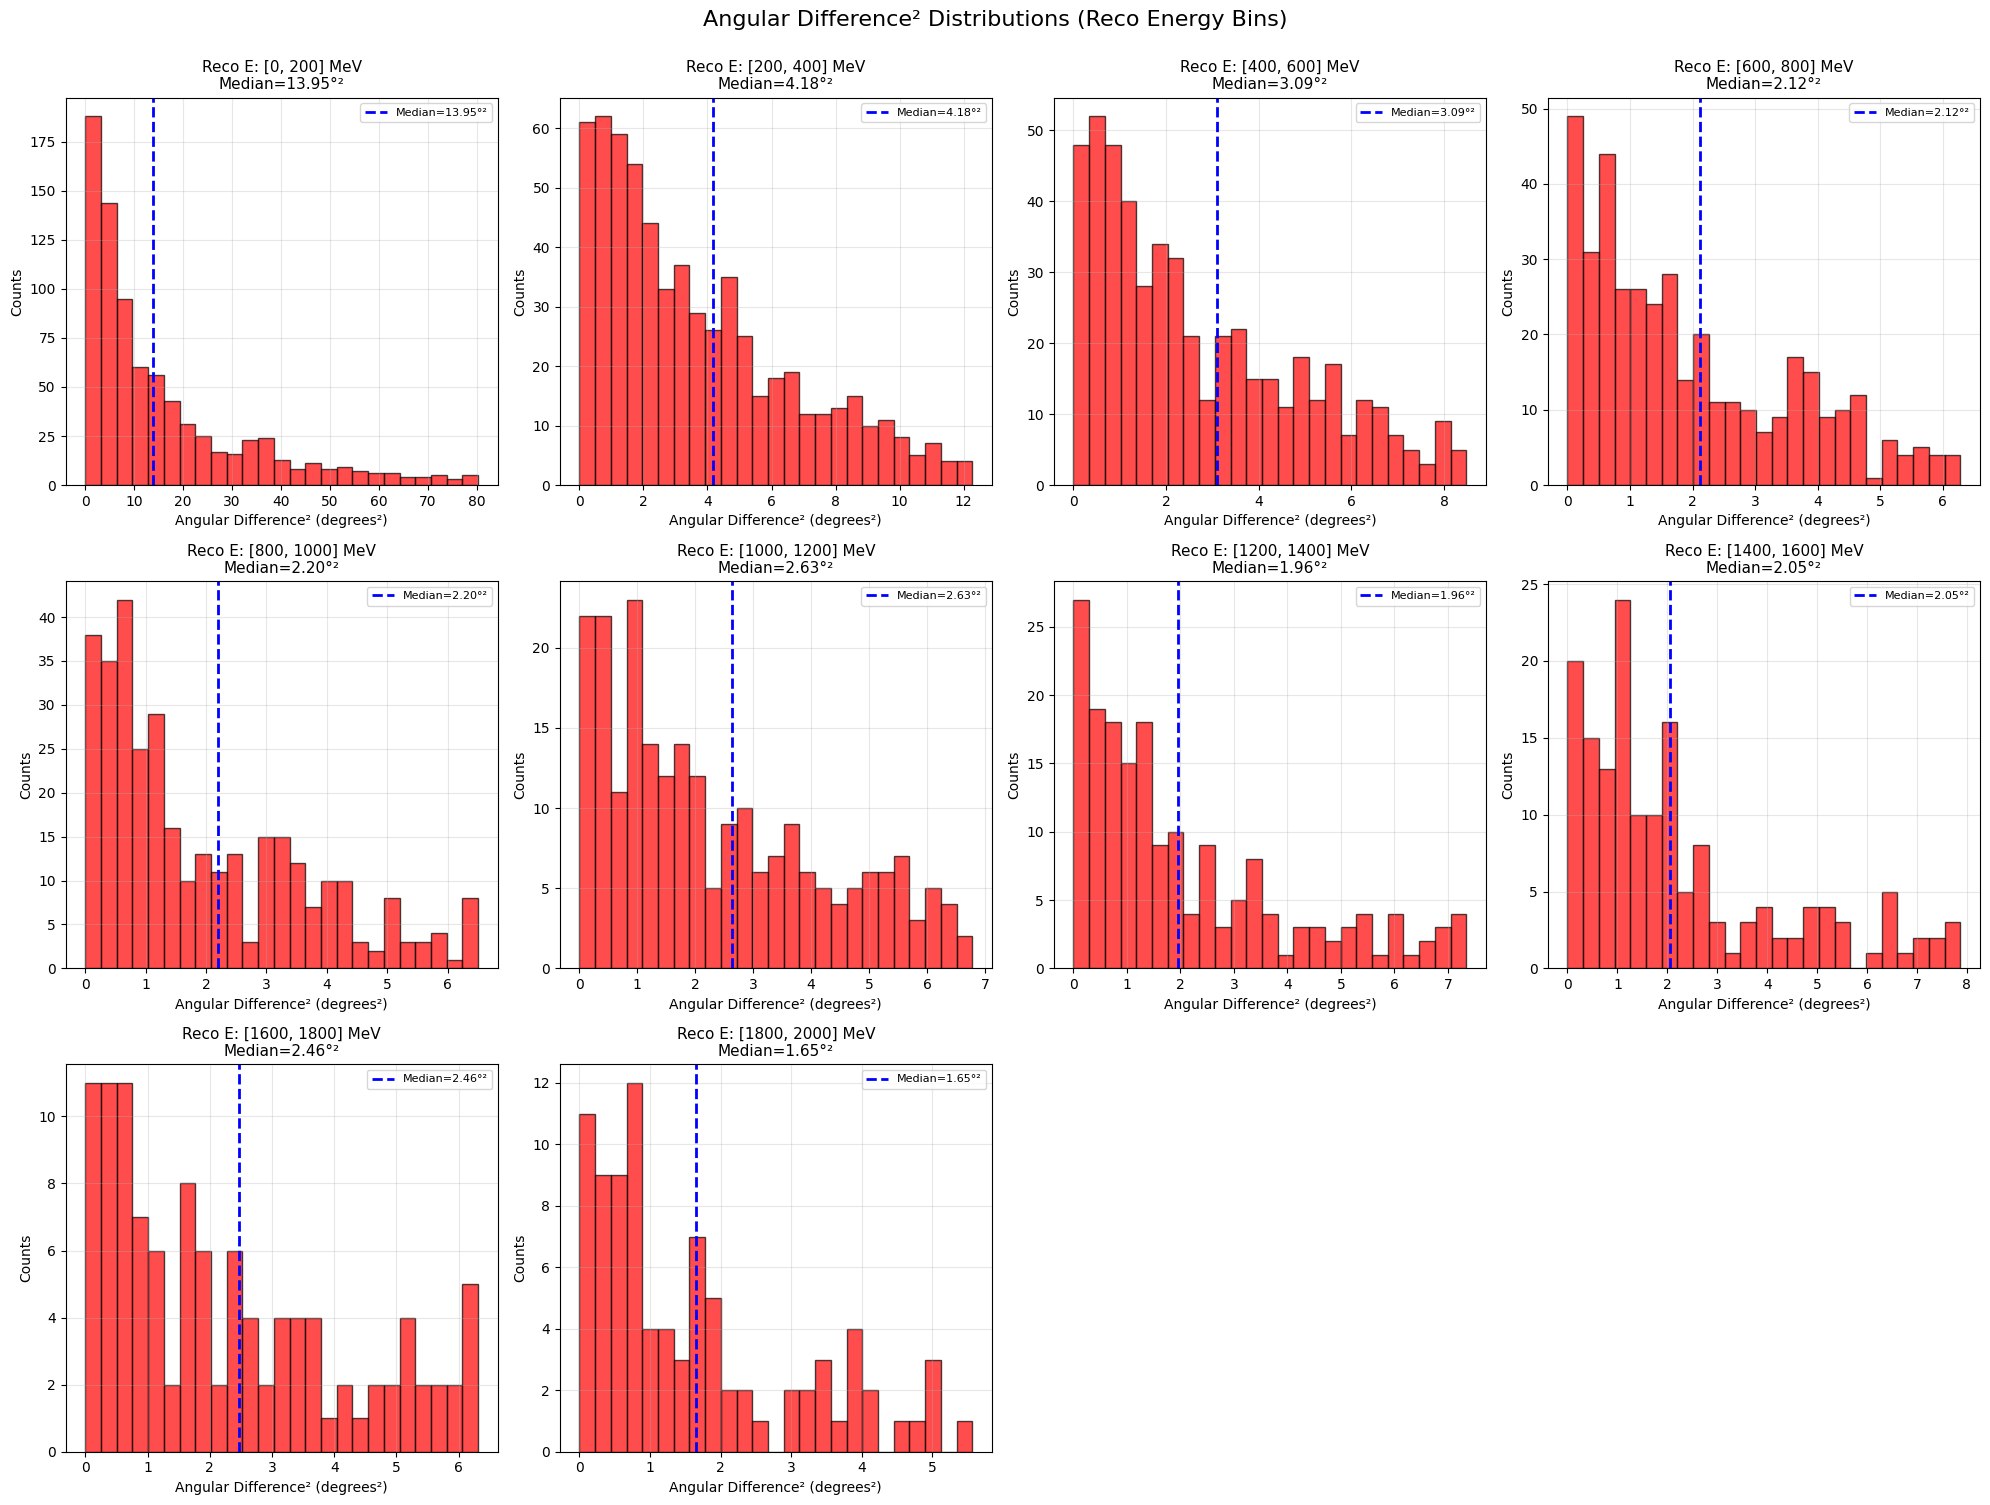


Median Analysis Complete


In [48]:
# Analyze angular difference distribution in 200 MeV energy bins and calculate median
import matplotlib.pyplot as plt
import numpy as np

# Set histogram parameters
HIST_DATA_PERCENTILE = 80  # Percentile of data to include in histogram range (%)
HIST_N_BINS = 25           # Number of bins for histogram

# Define energy bins (200 MeV intervals)
energy_bin_width = 200
energy_bins = np.arange(0, 2200, energy_bin_width)
n_bins = len(energy_bins) - 1

# Prepare data structures for True Energy analysis
true_median_list = []
true_bin_centers = []
true_hist_data = []  # Store histogram data for each bin

# Prepare data structures for Reco Energy analysis
reco_median_list = []
reco_bin_centers = []
reco_hist_data = []  # Store histogram data for each bin

# Process True Energy bins
print("=" * 80)
print("Processing True Energy Bins")
print("=" * 80)

for i in range(n_bins):
    e_min = energy_bins[i]
    e_max = energy_bins[i+1]
    bin_center = (e_min + e_max) / 2
    
    # Select data in this energy range
    mask = (np.array(true_energy_list) >= e_min) & (np.array(true_energy_list) < e_max)
    angles_squared_in_bin = np.array(start_dir_angle_diff_squared_list)[mask]
    
    if len(angles_squared_in_bin) > 10:  # Need sufficient statistics
        # Calculate histogram range based on data percentile
        x_max = np.percentile(angles_squared_in_bin, HIST_DATA_PERCENTILE)
        
        # Calculate median
        median_val = np.median(angles_squared_in_bin)
        
        true_median_list.append(median_val)
        true_bin_centers.append(bin_center)
        true_hist_data.append((angles_squared_in_bin, e_min, e_max, median_val, x_max))
        print(f"Energy bin [{e_min:.0f}, {e_max:.0f}] MeV: N={len(angles_squared_in_bin)}, Median={median_val:.2f}°², x_max={x_max:.2f}°²")

# Process Reco Energy bins
print("\n" + "=" * 80)
print("Processing Reco Energy Bins")
print("=" * 80)

for i in range(n_bins):
    e_min = energy_bins[i]
    e_max = energy_bins[i+1]
    bin_center = (e_min + e_max) / 2
    
    # Select data in this energy range
    mask = (np.array(reco_energy_list) >= e_min) & (np.array(reco_energy_list) < e_max)
    angles_squared_in_bin = np.array(start_dir_angle_diff_squared_list)[mask]
    
    if len(angles_squared_in_bin) > 10:  # Need sufficient statistics
        # Calculate histogram range based on data percentile
        x_max = np.percentile(angles_squared_in_bin, HIST_DATA_PERCENTILE)
        
        # Calculate median
        median_val = np.median(angles_squared_in_bin)
        
        reco_median_list.append(median_val)
        reco_bin_centers.append(bin_center)
        reco_hist_data.append((angles_squared_in_bin, e_min, e_max, median_val, x_max))
        print(f"Energy bin [{e_min:.0f}, {e_max:.0f}] MeV: N={len(angles_squared_in_bin)}, Median={median_val:.2f}°², x_max={x_max:.2f}°²")

# Plot 1: Median vs Energy (line plot)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# True Energy Median
axes[0].plot(true_bin_centers, true_median_list, 'o-', color='blue', linewidth=2, markersize=8, label='True Energy')
axes[0].set_xlabel('Energy (MeV)', fontsize=12)
axes[0].set_ylabel('Median (degrees²)', fontsize=12)
axes[0].set_title('Angular Difference² Median vs True Energy', fontsize=14)
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Reco Energy Median
axes[1].plot(reco_bin_centers, reco_median_list, 'o-', color='red', linewidth=2, markersize=8, label='Reco Energy')
axes[1].set_xlabel('Energy (MeV)', fontsize=12)
axes[1].set_ylabel('Median (degrees²)', fontsize=12)
axes[1].set_title('Angular Difference² Median vs Reco Energy', fontsize=14)
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

# Plot 2: All histograms for True Energy
n_true_bins = len(true_hist_data)
if n_true_bins > 0:
    n_cols = 4
    n_rows = int(np.ceil(n_true_bins / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (angles_squared, e_min, e_max, median_val, x_max) in enumerate(true_hist_data):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        counts, bins, patches = ax.hist(angles_squared, bins=HIST_N_BINS, range=(0, x_max), color='blue', alpha=0.7, edgecolor='black')
        
        # Add median line
        ax.axvline(x=median_val, color='red', linestyle='--', linewidth=2, label=f'Median={median_val:.2f}°²')
        
        ax.set_xlabel('Angular Difference² (degrees²)', fontsize=10)
        ax.set_ylabel('Counts', fontsize=10)
        ax.set_title(f'True E: [{e_min:.0f}, {e_max:.0f}] MeV\nMedian={median_val:.2f}°²', fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
    
    # Hide empty subplots
    for idx in range(n_true_bins, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].axis('off')
    
    plt.suptitle('Angular Difference² Distributions (True Energy Bins)', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.show()

# Plot 3: All histograms for Reco Energy
n_reco_bins = len(reco_hist_data)
if n_reco_bins > 0:
    n_cols = 4
    n_rows = int(np.ceil(n_reco_bins / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (angles_squared, e_min, e_max, median_val, x_max) in enumerate(reco_hist_data):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        counts, bins, patches = ax.hist(angles_squared, bins=HIST_N_BINS, range=(0, x_max), color='red', alpha=0.7, edgecolor='black')
        
        # Add median line
        ax.axvline(x=median_val, color='blue', linestyle='--', linewidth=2, label=f'Median={median_val:.2f}°²')
        
        ax.set_xlabel('Angular Difference² (degrees²)', fontsize=10)
        ax.set_ylabel('Counts', fontsize=10)
        ax.set_title(f'Reco E: [{e_min:.0f}, {e_max:.0f}] MeV\nMedian={median_val:.2f}°²', fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
    
    # Hide empty subplots
    for idx in range(n_reco_bins, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].axis('off')
    
    plt.suptitle('Angular Difference² Distributions (Reco Energy Bins)', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.show()

print("\n" + "=" * 80)
print("Median Analysis Complete")
print("=" * 80)